In [1]:
import pandas as pd
import numpy as np
from transformers import DebertaTokenizer, DebertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Suppress expected warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.metrics.cluster._supervised')
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.feature_selection')

# Add GPU count check at the top level
def get_available_gpus():
    """Get the number of available GPUs and their IDs"""
    if not torch.cuda.is_available():
        return 0, []
    
    n_gpus = torch.cuda.device_count()
    gpu_ids = list(range(n_gpus))
    return n_gpus, gpu_ids

def reduce_tokens_simple_truncation(text, tokenizer, max_length=512):
    """
    Simply truncate text to the maximum allowed token length.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Truncated text
    """
    tokens = tokenizer(text, truncation=True, max_length=max_length)
    return tokenizer.decode(tokens['input_ids'], skip_special_tokens=True)

def reduce_tokens_smart_truncation(text, tokenizer, max_length=512):
    """
    Intelligently truncate text by keeping the beginning and end portions.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Truncated text with beginning and end portions
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # Keep beginning and end portions (prioritize beginning slightly)
    beginning_length = max_length // 2 + 50  # Keep slightly more from beginning
    end_length = max_length - beginning_length - 1  # Reserve 1 for separator
    
    beginning_tokens = tokens[:beginning_length]
    end_tokens = tokens[-end_length:]
    
    # Combine with a separator token
    beginning_text = tokenizer.decode(beginning_tokens, skip_special_tokens=True)
    end_text = tokenizer.decode(end_tokens, skip_special_tokens=True)
    
    return f"{beginning_text} [...] {end_text}"

def reduce_tokens_extractive_summarization(text, tokenizer, max_length=512):
    """
    Reduce text length using extractive summarization techniques.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Summarized text
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # Import NLTK for sentence tokenization
    try:
        import nltk
        from nltk.tokenize import sent_tokenize
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt')
    except ImportError:
        # If NLTK is not available, fall back to smart truncation
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Split text into sentences
    sentences = sent_tokenize(text)
    
    if len(sentences) <= 3:
        # Not enough sentences to summarize meaningfully, use smart truncation
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Get sentence token lengths
    sentence_tokens = []
    for sentence in sentences:
        tokens = tokenizer(sentence, return_tensors="pt")["input_ids"][0]
        sentence_tokens.append((sentence, len(tokens)))
    
    # Calculate target ratio based on max length vs total length
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    reduction_ratio = max_length / len(tokens)
    
    # Always keep first and last sentences
    first_sentence, first_len = sentence_tokens[0]
    last_sentence, last_len = sentence_tokens[-1]
    
    remaining_length = max_length - first_len - last_len - 10  # Reserve some tokens for separators
    
    # If can't even fit first and last sentences, use smart truncation
    if remaining_length <= 0:
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Choose middle sentences based on importance (for now, just choose evenly distributed sentences)
    middle_sentences = sentence_tokens[1:-1]
    
    # Calculate how many middle sentences we can include
    middle_sentences_to_keep = []
    current_length = 0
    
    # Select sentences in a distributed manner
    if len(middle_sentences) > 0:
        # Fix: Add a check to prevent division by zero
        sentences_to_keep = int(reduction_ratio * len(middle_sentences))
        if sentences_to_keep <= 0:
            step = len(middle_sentences) + 1  # This will select only the first sentence if any
        else:
            step = max(1, len(middle_sentences) // sentences_to_keep)
            
        for i in range(0, len(middle_sentences), step):
            sentence, length = middle_sentences[i]
            if current_length + length <= remaining_length:
                middle_sentences_to_keep.append(sentence)
                current_length += length
            else:
                break
    
    # Combine sentences
    summarized_text = first_sentence
    
    if middle_sentences_to_keep:
        summarized_text += " " + " ".join(middle_sentences_to_keep)
    
    summarized_text += " " + last_sentence
    
    # Verify final length is within limit
    final_tokens = tokenizer(summarized_text, truncation=False, return_tensors="pt")["input_ids"][0]
    if len(final_tokens) > max_length:
        # Fall back to smart truncation if still too long
        return reduce_tokens_smart_truncation(summarized_text, tokenizer, max_length)
    
    return summarized_text

def reduce_tokens_hybrid(text, tokenizer, max_length=512):
    """
    Use a hybrid approach combining extractive summarization and smart truncation.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Processed text
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # For very long documents, use extractive summarization first
    if len(tokens) > max_length * 2:
        summarized = reduce_tokens_extractive_summarization(text, tokenizer, max_length)
        summarized_tokens = tokenizer(summarized, truncation=False, return_tensors="pt")["input_ids"][0]
        
        # If still too long, apply smart truncation
        if len(summarized_tokens) > max_length:
            return reduce_tokens_smart_truncation(summarized, tokenizer, max_length)
        return summarized
    
    # For moderately long documents, use smart truncation directly
    return reduce_tokens_smart_truncation(text, tokenizer, max_length)

def process_with_token_reduction(texts, tokenizer, max_length=512, strategy="smart_truncation"):
    """
    Process a series of texts by applying token reduction where necessary.
    
    Args:
        texts (pd.Series): Series of input texts
        tokenizer: Tokenizer to use for tokenization
        max_length (int): Maximum token length (default: 512)
        strategy (str): Token reduction strategy, one of:
            - "simple": Simple truncation at max_length
            - "smart_truncation": Keep beginning and end portions
            - "extractive_summarization": Use extractive summarization
            - "hybrid": Combine summarization and smart truncation
            
    Returns:
        pd.Series: Series with processed texts
    """
    processed_texts = []
    token_lengths_before = []
    token_lengths_after = []
    
    for text in tqdm(texts, desc=f"Applying token reduction ({strategy})"):
        # Calculate original token length
        tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
        token_lengths_before.append(len(tokens))
        
        # Only process if longer than max_length
        if len(tokens) <= max_length:
            processed_texts.append(text)
            token_lengths_after.append(len(tokens))
            continue
        
        # Apply selected strategy
        if strategy == "simple":
            processed_text = reduce_tokens_simple_truncation(text, tokenizer, max_length)
        elif strategy == "smart_truncation":
            processed_text = reduce_tokens_smart_truncation(text, tokenizer, max_length)
        elif strategy == "extractive_summarization":
            processed_text = reduce_tokens_extractive_summarization(text, tokenizer, max_length)
        elif strategy == "hybrid":
            processed_text = reduce_tokens_hybrid(text, tokenizer, max_length)
        else:
            # Default to smart truncation
            processed_text = reduce_tokens_smart_truncation(text, tokenizer, max_length)
        
        processed_texts.append(processed_text)
        
        # Calculate new token length
        new_tokens = tokenizer(processed_text, truncation=False, return_tensors="pt")["input_ids"][0]
        token_lengths_after.append(len(new_tokens))
    
    # Print statistics
    print(f"\nToken reduction statistics using {strategy} strategy:")
    print(f"  Before:")
    print(f"    Mean length: {np.mean(token_lengths_before):.2f}")
    print(f"    Median length: {np.median(token_lengths_before):.2f}")
    print(f"    Max length: {max(token_lengths_before)}")
    print(f"    Docs exceeding {max_length} tokens: {sum(1 for l in token_lengths_before if l > max_length)} ({sum(1 for l in token_lengths_before if l > max_length)/len(token_lengths_before)*100:.2f}%)")
    
    print(f"  After:")
    print(f"    Mean length: {np.mean(token_lengths_after):.2f}")
    print(f"    Median length: {np.median(token_lengths_after):.2f}")
    print(f"    Max length: {max(token_lengths_after)}")
    print(f"    Docs exceeding {max_length} tokens: {sum(1 for l in token_lengths_after if l > max_length)} ({sum(1 for l in token_lengths_after if l > max_length)/len(token_lengths_after)*100:.2f}%)")
    
    # Optional: Create histogram plot
    try:
        plt.figure(figsize=(10, 6))
        plt.hist([token_lengths_before, token_lengths_after], bins=30, 
                 label=['Before reduction', 'After reduction'], alpha=0.7)
        plt.axvline(x=max_length, color='r', linestyle='--', label=f'Max length ({max_length})')
        plt.title(f'Token Length Distribution Before and After {strategy}')
        plt.xlabel('Number of Tokens')
        plt.ylabel('Frequency')
        plt.legend()
        plt.savefig(f'token_reduction_{strategy}.png')
        plt.close()
        print(f"  Distribution plot saved as token_reduction_{strategy}.png")
    except Exception as e:
        print(f"  Could not create distribution plot: {str(e)}")
    
    return pd.Series(processed_texts, index=texts.index)

def calculate_token_lengths(texts, tokenizer):
    """
    Calculate the token length for each text sample using the specified tokenizer.
    
    Args:
        texts (pd.Series): Series of input texts
        tokenizer: Tokenizer to use for tokenization
        
    Returns:
        pd.Series: Series containing the token length of each text
    """
    token_lengths = []
    for text in tqdm(texts, desc="Calculating token lengths"):
        tokens = tokenizer(str(text), truncation=False, return_tensors="pt")
        token_lengths.append(len(tokens['input_ids'][0]))
    
    return pd.Series(token_lengths, index=texts.index)

def filter_outliers_by_token_length(texts, token_lengths, std_threshold=3.0, min_token_threshold=None):
    """
    Filter out text samples with token lengths beyond a certain standard deviation threshold.
    
    Args:
        texts (pd.Series): Series of input texts
        token_lengths (pd.Series): Series containing token length of each text
        std_threshold (float): Standard deviation threshold (default: 3.0)
        min_token_threshold (int, optional): Minimum number of tokens required (default: None)
        
    Returns:
        tuple: Filtered texts and boolean mask to apply to original data
    """
    mean_length = token_lengths.mean()
    std_length = token_lengths.std()
    
    # Print original token statistics
    print(f"Token length statistics before filtering:")
    print(f"  Mean: {mean_length:.2f}, Std Dev: {std_length:.2f}")
    print(f"  Min: {token_lengths.min()}, Max: {token_lengths.max()}")
    print(f"  25th percentile: {token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {token_lengths.quantile(0.75):.2f}")
    
    # Original data size
    original_size = len(texts)
    
    # Start with all True mask for the original data
    final_mask = pd.Series(True, index=texts.index)
    
    # Step 1: Apply standard deviation filtering if std_threshold is provided
    if std_threshold < float('inf'):
        # Define upper and lower bounds
        upper_bound = mean_length + std_threshold * std_length
        lower_bound = mean_length - std_threshold * std_length
        lower_bound = max(1, lower_bound)  # Ensure lower bound is at least 1
        
        # Create mask for samples within bounds
        std_mask = (token_lengths >= lower_bound) & (token_lengths <= upper_bound)
        
        # Update final mask with standard deviation condition
        final_mask = final_mask & std_mask
        
        std_removed = (~std_mask).sum()
        print(f"Applied {std_threshold} std dev threshold: ({lower_bound:.2f}, {upper_bound:.2f})")
        print(f"Removed {std_removed} samples by std dev filtering ({std_removed/original_size*100:.2f}% of data)")
    
    # Step 2: Apply minimum token threshold if specified
    if min_token_threshold is not None:
        # Create mask for minimum token threshold
        min_token_mask = token_lengths >= min_token_threshold
        
        # Track how many would be removed by this filter
        min_token_removed = (~min_token_mask).sum()
        
        # Track how many would be removed by this filter that weren't already filtered by std
        additional_removed = ((~min_token_mask) & final_mask).sum()
        
        # Update final mask with minimum token threshold condition
        final_mask = final_mask & min_token_mask
        
        print(f"Applied minimum token threshold of {min_token_threshold}")
        print(f"Removed {min_token_removed} samples below minimum token threshold ({min_token_removed/original_size*100:.2f}% of original data)")
        print(f"Of which {additional_removed} weren't already filtered by std deviation ({additional_removed/original_size*100:.2f}% of original data)")
    
    # Apply final mask to get filtered data
    filtered_texts = texts[final_mask]
    filtered_token_lengths = token_lengths[final_mask]
    
    # Calculate total removed
    total_removed = (~final_mask).sum()
    print(f"Total removed: {total_removed} samples ({total_removed/original_size*100:.2f}% of original data)")
    print(f"Remaining: {final_mask.sum()} samples ({final_mask.sum()/original_size*100:.2f}% of original data)")

    # Print final statistics
    print(f"\nToken length statistics after all filtering:")
    print(f"  Mean: {filtered_token_lengths.mean():.2f}, Std Dev: {filtered_token_lengths.std():.2f}")
    print(f"  Min: {filtered_token_lengths.min()}, Max: {filtered_token_lengths.max()}")
    print(f"  25th percentile: {filtered_token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {filtered_token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {filtered_token_lengths.quantile(0.75):.2f}")
    
    return filtered_texts, final_mask

class IssueDataset(Dataset):
    """
    Dataset for processing text data and multi-label classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # For multi-label classification, ensure we're passing the full label array
        # and not just a single value
        label = self.labels[idx]
        
        # Make sure we're getting a proper multi-dimensional label array
        # and not flattening it incorrectly
        if isinstance(label, (list, np.ndarray)):
            # Convert directly to tensor without modifying shape
            label = torch.tensor(label, dtype=torch.float)
        else:
            # If it's not already an array-like structure, this is likely a mistake
            # as we expect multi-label one-hot encoded data
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': label
        }
    
class DeBERTaClassifier(nn.Module):
    """
    A classifier model based on DeBERTa for multi-label classification.
    
    This model uses a pre-trained DeBERTa model as the encoder and adds a 
    classification head on top with sigmoid activation for multi-label output.
    
    Args:
        num_labels (int): Number of classes in the multi-label classification task.
    """
    def __init__(self, num_labels):
        super().__init__()
        self.deberta = DebertaModel.from_pretrained('microsoft/deberta-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        # Freeze all parameters in DeBERTa
        for param in self.deberta.parameters():
            param.requires_grad = False
        # Unfreeze encoder parameters for fine-tuning
        # Note: DeBERTa has a different architecture than BERT/RoBERTa
        # We'll unfreeze the last 3 encoder layers
        for layer in self.deberta.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        # Unlike BERT, DeBERTa doesn't have a pooler, so we need to take the last hidden state
        # and either use the [CLS] token (first token) or do mean pooling
        # Here we'll use the [CLS] token (first token) representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        # Return raw logits for BCEWithLogitsLoss (sigmoid will be applied in the loss function)
        return self.classifier(cls_output)
    
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False


def train_epoch(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch, computing loss and metrics for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        threshold (float): Threshold for binary predictions (default is 0.5).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, Hamming accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics for multi-label classification
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Use subset accuracy (exact match) for a strict measure
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False
    

def validate(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        device: Device to perform evaluation.
        threshold (float): Threshold for binary predictions (default is 0.5).

    Returns:
        tuple: Average loss, various accuracy metrics, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate different multi-label metrics
    
    # 1. Exact Match / Subset Accuracy (all labels must be correct)
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    # 2. Partial Match Accuracy (only count correctly predicted 1s, ignore 0s)
    # Calculate true positives per sample
    true_positives = np.logical_and(all_preds == 1, all_labels == 1).sum(axis=1)
    # Calculate total actual positives per sample
    total_positives = (all_labels == 1).sum(axis=1)
    # Handle division by zero - samples with no positive labels get a score of 0
    partial_match = np.zeros_like(true_positives, dtype=float)
    # Only calculate ratio for samples with at least one positive label
    mask = total_positives > 0
    partial_match[mask] = true_positives[mask] / total_positives[mask]
    partial_match_accuracy = partial_match.mean()
    
    # 3. Jaccard Similarity (intersection over union)
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        # Create a float array for output to avoid type casting error
        result = np.zeros_like(intersection, dtype=float)
        # Avoid division by zero
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    
    # Add Hamming metric - this is the same as partial_match_accuracy
    hamming_sim = partial_match_accuracy
    
    # Sample-based metrics - Each sample contributes equally regardless of number of labels
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": exact_match, 
             "partial_match": partial_match_accuracy,
             "hamming": hamming_sim,
             "jaccard": jaccard_sim}, 
            precision, recall, f1)

def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    
    Args:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted binary labels.
        class_names (list): Names of the classes/labels.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])  # Make it indexable for single class
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:  # Ensure we don't exceed the number of classes
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    return fig

def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0, tokenizer=None, token_std_threshold=None, min_token_threshold=None):
    """
    Filter out infrequent labels, samples with too many labels, and token length outliers.
    
    Args:
        df (pd.DataFrame): DataFrame with text column and 'labels'
        text_column (str): Name of the column containing the text data to use
        min_label_freq (int): Minimum frequency for a label to be considered frequent.
        max_label_len (int): Maximum number of labels per sample.
        min_label_comb_freq (int): Minimum frequency for a label combination to be kept.
        tokenizer: Tokenizer to use for token length calculation (required if token_std_threshold is provided)
        token_std_threshold (float, optional): Standard deviation threshold for filtering token length outliers.
            If None, no token length filtering is applied. Common values are 2.0 or 3.0.
        min_token_threshold (int, optional): Minimum number of tokens required for a sample.
            If None, no minimum token threshold is applied.

    Returns:
        tuple: Filtered texts and labels.
    """
    # Print initial dataset size
    initial_size = len(df)
    print(f"\n=== DATA PREPROCESSING STATISTICS ===")
    print(f"Initial dataset size: {initial_size}")
    
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        before_nan_filter = len(df)
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
        nan_removed = before_nan_filter - len(df)
        if nan_removed > 0:
            print(f"Step 1: Removed {nan_removed} rows with 'nan' text ({nan_removed/before_nan_filter*100:.2f}% of data)")
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    before_na_drop = len(df)
    df = df.dropna()
    na_removed = before_na_drop - len(df)
    if na_removed > 0:
        print(f"Step 2: Removed {na_removed} rows with missing labels ({na_removed/before_na_drop*100:.2f}% of data)")
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    current_size = len(texts)
    print(f"Dataset size after basic cleaning: {current_size} ({current_size/initial_size*100:.2f}% of original data)")

    # Filter by token length if requested
    if (token_std_threshold is not None or min_token_threshold is not None) and tokenizer is not None:
        print(f"\nStep 3: Filtering by token length...")
        if token_std_threshold is not None:
            print(f"Using {token_std_threshold} standard deviation threshold")
        if min_token_threshold is not None:
            print(f"Using minimum token threshold of {min_token_threshold}")
        
        # Calculate token lengths
        token_lengths = calculate_token_lengths(texts, tokenizer)
        
        # Apply token length filtering
        before_token_filter = len(texts)
        filtered_texts, token_mask = filter_outliers_by_token_length(
            texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=min_token_threshold
        )
        # Apply same filter to labels
        filtered_labels = labels[token_mask].reset_index(drop=True)
        token_removed = before_token_filter - len(filtered_texts)
        print(f"Removed {token_removed} samples by token length filtering ({token_removed/before_token_filter*100:.2f}% of data)")
        print(f"Texts after token length filtering: {len(filtered_texts)} ({len(filtered_texts)/initial_size*100:.2f}% of original data)")

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])
    total_labels_before = len(label_distribution)
    print(f"\nStep 4: Filtering infrequent labels (min frequency: {min_label_freq})")
    print(f"Total unique labels before filtering: {total_labels_before}")

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    labels_removed = total_labels_before - len(frequent_labels)
    
    # Prevent division by zero
    if total_labels_before > 0:
        print(f"Removed {labels_removed} infrequent labels ({labels_removed/total_labels_before*100:.2f}% of labels)")
        print(f"Number of labels remaining: {len(frequent_labels)} ({len(frequent_labels)/total_labels_before*100:.2f}% of labels)")
    else:
        print(f"Removed {labels_removed} infrequent labels (0.00% of labels)")
        print(f"Number of labels remaining: {len(frequent_labels)} (0.00% of labels)")

    # Filter out infrequent labels
    before_label_filter = len(labels)
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    
    # Count samples that have no labels after filtering
    empty_labels_mask = filtered_labels.apply(len) > 0
    empty_labels_count = (~empty_labels_mask).sum()
    if empty_labels_count > 0:
        print(f"Warning: {empty_labels_count} samples ({empty_labels_count/before_label_filter*100:.2f}%) now have no labels due to label frequency filtering")
        # Remove samples with no labels
        filtered_labels = filtered_labels[empty_labels_mask]
        texts = texts[empty_labels_mask]
        print(f"Removed {empty_labels_count} samples with no labels")
    
    print(f"Samples remaining after label filtering: {len(filtered_labels)} ({len(filtered_labels)/before_label_filter*100:.2f}% of data)")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    total_combinations_before = len(label_combinations)
    
    print(f"\nStep 5: Filtering infrequent label combinations (min frequency: {min_label_comb_freq})")
    print(f"Total unique label combinations before filtering: {total_combinations_before}")
    
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    combinations_removed = total_combinations_before - len(frequent_combinations)
    
    # Prevent division by zero
    if total_combinations_before > 0:
        print(f"Removed {combinations_removed} infrequent label combinations ({combinations_removed/total_combinations_before*100:.2f}% of combinations)")
        print(f"Number of label combinations remaining: {len(frequent_combinations)} ({len(frequent_combinations)/total_combinations_before*100:.2f}% of combinations)")
    else:
        print(f"Removed {combinations_removed} infrequent label combinations (0.00% of combinations)")
        print(f"Number of label combinations remaining: {len(frequent_combinations)} (0.00% of combinations)")
    
    # Create mask for samples with frequent label combinations (if min_label_comb_freq > 0)
    if min_label_comb_freq > 0:
        before_comb_filter = len(filtered_labels)
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        samples_removed_by_comb = before_comb_filter - comb_mask.sum()
        print(f"Removed {samples_removed_by_comb} samples with infrequent label combinations ({samples_removed_by_comb/before_comb_filter*100:.2f}% of data)")
        print(f"Samples remaining after combination filtering: {comb_mask.sum()} ({comb_mask.sum()/before_comb_filter*100:.2f}% of data)")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    print(f"\nStep 6: Filtering samples with too many labels (max labels per sample: {max_label_len})")
    before_length_filter = len(filtered_labels)
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    samples_removed_by_length = before_length_filter - length_mask.sum()
    print(f"Removed {samples_removed_by_length} samples with too many or zero labels ({samples_removed_by_length/before_length_filter*100:.2f}% of data)")
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"\n=== FINAL PREPROCESSING RESULTS ===")
    print(f"Original dataset size: {initial_size}")
    print(f"Final dataset size: {len(filtered_labels)} ({len(filtered_labels)/initial_size*100:.2f}% of original data)")
    print(f"Total samples removed: {initial_size - len(filtered_labels)} ({(initial_size - len(filtered_labels))/initial_size*100:.2f}% of original data)")
    
    return texts, filtered_labels

# Add hybrid feature selection function
def hybrid_feature_selection(texts, labels_encoded, mlb, top_k_filter=20, top_k_final=10, vectorizer=None, random_seed=42, wrapper_method='rf'):
    """
    Perform hybrid feature selection using both filter and wrapper methods.
    
    Args:
        texts (pd.Series): Series of text data
        labels_encoded (np.array): One-hot encoded labels
        mlb (MultiLabelBinarizer): Label encoder used for transforming labels
        top_k_filter (int): Number of labels to retain after filter stage
        top_k_final (int): Final number of labels to select
        vectorizer (object): Text vectorizer with fit_transform method. If None, uses simple word count
        random_seed (int): Random seed for reproducibility
        wrapper_method (str): Wrapper method to use ('rf' for Random Forest or 'lr' for Logistic Regression)
        
    Returns:
        tuple: Selected indices, selected label names, and feature importance scores
    """
    print(f"Starting hybrid feature selection to select {top_k_final} out of {labels_encoded.shape[1]} labels...")
    
    # If no vectorizer provided, create a simple one using sklearn's CountVectorizer
    if vectorizer is None:
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer = CountVectorizer(max_features=5000)
    
    # Transform texts to feature vectors
    print("Vectorizing text data...")
    X_vec = vectorizer.fit_transform(texts)
    
    # STEP 1: Filter Method - Use chi-square test and mutual information
    print("Applying filter methods...")
    
    # Store scores from multiple filter methods
    feature_scores = np.zeros(labels_encoded.shape[1])
    
    # Chi-square test for each label
    for i in range(labels_encoded.shape[1]):
        chi_scores = chi2(X_vec, labels_encoded[:, i])
        feature_scores[i] += chi_scores[0].mean()  # Add chi-square statistic
    
    # Mutual information for each label
    for i in range(labels_encoded.shape[1]):
        mi_score = mutual_info_classif(X_vec, labels_encoded[:, i], random_state=random_seed)
        feature_scores[i] += mi_score.mean() * 10  # Scale and add MI score
    
    # Get top-k features from filter methods
    filter_selected_indices = np.argsort(-feature_scores)[:top_k_filter]
    filter_selected_labels = np.array(mlb.classes_)[filter_selected_indices]
    
    print(f"Filter stage selected {len(filter_selected_indices)} labels")
    
    # STEP 2: Wrapper Method - Use specified model to evaluate feature subsets
    print(f"Applying wrapper method using {wrapper_method.upper()}...")
    
    # Initialize the appropriate model based on wrapper_method
    if wrapper_method.lower() == 'rf':
        model = RandomForestClassifier(n_estimators=100, random_state=random_seed, n_jobs=-1)
    elif wrapper_method.lower() == 'lr':
        model = LogisticRegression(random_state=random_seed, max_iter=1000)
    else:
        raise ValueError(f"Unsupported wrapper method: {wrapper_method}. Use 'rf' or 'lr'.")
    
    X_filtered = labels_encoded[:, filter_selected_indices]
    
    # For wrapper method, we'll create a matrix where each sample is label presence/absence
    # and the target is other labels - a proxy for how well each label predicts others
    importance_scores = np.zeros(len(filter_selected_indices))
    
    # For each label, train a model to predict it using the other labels
    for i in tqdm(range(len(filter_selected_indices)), desc="Wrapper evaluation"):
        # Current target label
        y = X_filtered[:, i]
        
        # Features (other labels)
        X_others = np.delete(X_filtered, i, axis=1)
        
        # Train model
        model.fit(X_others, y)
        
        # Score based on model performance
        accuracy = model.score(X_others, y)
        importance_scores[i] = accuracy
    
    # STEP 3: Combine scores to select final features
    final_scores = 0.6 * feature_scores[filter_selected_indices] + 0.4 * importance_scores
    final_selected_indices = filter_selected_indices[np.argsort(-final_scores)[:top_k_final]]
    final_selected_labels = np.array(mlb.classes_)[final_selected_indices]
    
    print(f"Final selection: {len(final_selected_labels)} labels")
    print("Selected labels:", final_selected_labels)
    
    return final_selected_indices, final_selected_labels, final_scores

def main(args):
    """
    Main function to run the multi-label classification pipeline with DeBERTa.
    This function loads data, preprocesses it, trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    n_gpus, gpu_ids = get_available_gpus()
    if n_gpus >= 2:
        print(f"Using {n_gpus} GPUs: {gpu_ids}")
        device = torch.device("cuda")
        use_multi_gpu = True
    elif n_gpus == 1:
        print("Using 1 GPU")
        device = torch.device("cuda")
        use_multi_gpu = False
    else:
        print("No GPUs available, using CPU")
        device = torch.device("cpu")
        use_multi_gpu = False
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Load data
    print(f"Loading data from {args.data_path}...")
    # Check file extension to determine loading method
    if args.data_path.endswith('.json'):
        df = pd.read_json(args.data_path)
    elif args.data_path.endswith('.csv'):
        df = pd.read_csv(args.data_path)
        # Convert string representation of lists to actual lists if needed
        if 'labels' in df.columns and isinstance(df['labels'].iloc[0], str):
            try:
                df['labels'] = df['labels'].apply(eval)  # Convert string representation of list to actual list
            except:
                print("Warning: Failed to convert 'labels' column from string to list. Check format.")
    else:
        raise ValueError(f"Unsupported file format: {args.data_path}. Use .json or .csv")
    
    # Check if the text column exists
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Load the tokenizer for token length calculations
    print("Loading tokenizer...")
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    
    # Extract issue texts and labels
    texts = df[args.text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    
    # Determine token length filtering threshold based on args
    token_std_threshold = None
    if args.token_length_filter == '3std':
        token_std_threshold = 3.0
    elif args.token_length_filter == '2std':
        token_std_threshold = 2.0
    
    # Apply token length filtering first if requested
    if token_std_threshold is not None or args.min_token_threshold is not None:
        print(f"\nApplying token length filtering...")
        token_lengths = calculate_token_lengths(texts, tokenizer)
        
        # First filter by standard deviation, then by min threshold (in sequence)
        filtered_texts, token_mask = filter_outliers_by_token_length(
            texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=args.min_token_threshold
        )
        
        # Apply same filter to labels and dataframe - keep original indices
        filtered_labels = labels[token_mask]
        filtered_df = df[token_mask]
        
        # Now reset indices for further processing
        texts = filtered_texts.reset_index(drop=True)
        labels = filtered_labels.reset_index(drop=True)
        filtered_df = filtered_df.reset_index(drop=True)
    else:
        filtered_df = df
    
    # Apply token reduction if requested (after outlier removal)
    if args.token_reduction_strategy:
        print(f"\nApplying token reduction strategy: {args.token_reduction_strategy}")
        texts = process_with_token_reduction(
            texts, 
            tokenizer, 
            max_length=args.max_length, 
            strategy=args.token_reduction_strategy
        )
        # Update filtered_df with the reduced texts
        filtered_df[args.text_column] = texts
    
    # Use prepare_data function to filter and prepare data, but skip token length filtering since we've done it
    texts, filtered_labels = prepare_data(
        filtered_df,
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq,
        tokenizer=tokenizer,
        token_std_threshold=None,  # Set to None to skip the token filtering in prepare_data
        min_token_threshold=args.min_token_threshold
    )
    
    # Print final dataset statistics
    print("\n=== FINAL DATASET STATISTICS ===")
    print(f"Initial dataset size: {len(df)}")
    print(f"Final dataset size: {len(texts)}")
    print(f"Total samples removed: {len(df) - len(texts)} ({(len(df) - len(texts))/len(df)*100:.2f}% of original data)")
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\nLabel Distribution:')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\nLabel count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')
    
    # Save preprocessing metadata
    preprocessing_metadata = {
        'initial_dataset_size': len(df),
        'final_dataset_size': len(texts),
        'token_reduction': {
            'applied': args.token_reduction_strategy is not None,
            'strategy': args.token_reduction_strategy if args.token_reduction_strategy else None,
            'max_length': args.max_length
        },
        'token_length_filtering': {
            'applied': token_std_threshold is not None,
            'threshold': token_std_threshold
        },
        'label_filtering': {
            'min_label_freq': args.min_label_freq,
            'max_label_len': args.max_label_len,
            'min_label_comb_freq': args.min_label_comb_freq
        },
        'min_token_threshold': {
            'applied': args.min_token_threshold is not None,
            'threshold': args.min_token_threshold
        }
    }
    
    # Calculate and add max token length to metadata
    if tokenizer is not None:
        token_lengths = calculate_token_lengths(texts, tokenizer)
        max_token_length = int(token_lengths.max())
        preprocessing_metadata['token_stats'] = {
            'max_token_length': max_token_length,
            'mean_token_length': float(token_lengths.mean()),
            'median_token_length': float(token_lengths.median())
        }
        print(f"\n=== TOKEN LENGTH SUMMARY ===")
        print(f"Maximum token length: {max_token_length}")
        print(f"Mean token length: {token_lengths.mean():.2f}")
        print(f"Median token length: {token_lengths.median():.2f}")
    
    with open(os.path.join(run_dir, 'preprocessing_metadata.json'), 'w') as f:
        json.dump(preprocessing_metadata, f, indent=4)
    
    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Save all original label classes
    all_classes = mlb.classes_.tolist()
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': all_classes
        }, f)
    
    # Calculate label distribution
    label_counts = labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (labels_encoded.shape[0] * labels_encoded.shape[1])
    print(f"Label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / labels_encoded.shape[0]:.2f}")
    
    # print hybrid feature selection args
    print(f"Feature selection enabled: {args.feature_selection}")
    if args.feature_selection:
        print(f"Filter top-k: {args.filter_k}, Final top-k: {args.final_k}")
        print(f"Wrapper method: {args.wrapper_method.upper()}")
    else : 
        print("Feature selection disabled")
    # Perform hybrid feature selection if enabled
    if args.feature_selection:
        print(f"\nPerforming hybrid feature selection...")
        
        # Create appropriate vectorizer based on argument
        if args.vectorizer == 'tfidf':
            from sklearn.feature_extraction.text import TfidfVectorizer
            vectorizer = TfidfVectorizer(max_features=5000)
            print("Using TF-IDF vectorizer for feature selection")
        else:  # default to count
            from sklearn.feature_extraction.text import CountVectorizer
            vectorizer = CountVectorizer(max_features=5000)
            print("Using Count vectorizer for feature selection")
        
        selected_indices, selected_labels, feature_scores = hybrid_feature_selection(
            texts, labels_encoded, mlb, 
            top_k_filter=args.filter_k,
            top_k_final=args.final_k,
            vectorizer=vectorizer,
            random_seed=42,
            wrapper_method=args.wrapper_method
        )
        
        # Filter labels_encoded to keep only selected labels
        labels_encoded = labels_encoded[:, selected_indices]
        
        # Save selected labels to file
        with open(os.path.join(run_dir, 'selected_labels.json'), 'w') as f:
            json.dump({
                'selected_labels': selected_labels.tolist(),
                'feature_scores': feature_scores.tolist(),
                'selected_indices': selected_indices.tolist(),
                'vectorizer_type': args.vectorizer,
                'wrapper_method': args.wrapper_method
            }, f)
        
        # Update mlb.classes_ to only contain selected classes
        mlb.classes_ = np.array(selected_labels)
        
        # Recalculate label counts with selected labels
        label_counts = labels_encoded.sum(axis=0)
        print(f"Training with {len(selected_labels)} selected labels: {selected_labels}")
    else:
        print("Feature selection disabled, using all labels")
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if args.use_class_weights and label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = args.batch_size
    train_dataset = IssueDataset(train_texts, train_labels, tokenizer, max_length=args.max_length)
    val_dataset = IssueDataset(val_texts, val_labels, tokenizer, max_length=args.max_length)
    
    # Increase batch size for DataParallel if multiple GPUs
    if use_multi_gpu:
        batch_size = batch_size * n_gpus
        print(f"Using larger batch size of {batch_size} for {n_gpus} GPUs")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    model = DeBERTaClassifier(num_labels=len(mlb.classes_)).to(device)
    
    # Use DataParallel for multiple GPUs
    if use_multi_gpu:
        model = nn.DataParallel(model)
        print("Model wrapped in DataParallel")
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=args.patience, min_delta=0.01)
    
    # Training loop
    num_epochs = args.epochs
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    best_model_saved = False  # Flag to track if we've saved at least one model
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Partial Match): {accuracy_metrics['partial_match']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            
            # Save the model state_dict (handle DataParallel wrapper if needed)
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
                
            print(f"Saved new best model to {model_path}")
            best_model_saved = True
        
        # Always save a model for the first epoch if no model has been saved yet
        # This ensures we have at least one model if early stopping occurs
        if epoch == 0 and not best_model_saved:
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
            print(f"Saved initial model to {model_path} as baseline")
            best_model_saved = True
            
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    with open(os.path.join(run_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    best_model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
    
    # Handle loading for DataParallel model
    if use_multi_gpu:
        model.module.load_state_dict(torch.load(best_model_path))
    else:
        model.load_state_dict(torch.load(best_model_path))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Partial Match Accuracy: {final_acc_metrics['partial_match']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Save results
    results = {
        'text_column': args.text_column,
        'token_length_filter': args.token_length_filter,
        'token_reduction_strategy': args.token_reduction_strategy,
        'metrics': {
            'exact_match': float(final_acc_metrics['exact_match']),
            'partial_match': float(final_acc_metrics['partial_match']),
            'jaccard': float(final_acc_metrics['jaccard']),
            'precision': float(final_precision),
            'recall': float(final_recall), 
            'f1': float(final_f1),
        }
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.savefig(os.path.join(run_dir, 'confusion_matrices.png'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History - {args.text_column}')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'training_history.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': results['metrics'],
        'model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }

2025-05-17 09:00:35.810237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747472436.321016      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747472436.446854      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# with weighted class

# 0.5

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-bug-data-comments-without-filenames/Bug Data with comments without changed files.csv...
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]


Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:04<00:00, 260.32it/s]


Token length statistics before filtering:
  Mean: 548.88, Std Dev: 858.81
  Min: 9, Max: 12309
  25th percentile: 135.00
  50th percentile (median): 285.00
  75th percentile: 612.00
Applied 3.0 std dev threshold: (1.00, 3125.31)
Removed 18 samples by std dev filtering (1.43% of data)
Total removed: 18 samples (1.43% of original data)
Remaining: 1240 samples (98.57% of original data)

Token length statistics after all filtering:
  Mean: 475.48, Std Dev: 528.15
  Min: 9, Max: 3059
  25th percentile: 134.00
  50th percentile (median): 281.50
  75th percentile: 591.50

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1240
Dataset size after basic cleaning: 1240 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1225 (98.79% of data)

Ste

Calculating token lengths: 100%|██████████| 1101/1101 [00:03<00:00, 351.05it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 3059
Mean token length: 468.63
Median token length: 265.00
Encoding labels...
Label density: 0.0634
Average labels per sample: 1.21
Feature selection enabled: False
Feature selection disabled
Feature selection disabled, using all labels
Training samples: 880, Validation samples: 221
Loading tokenizer...
Computing class weights for imbalanced labels...
Using larger batch size of 32 for 2 GPUs
Initializing model...


pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Model wrapped in DataParallel
Using weighted BCE loss
Starting training for 30 epochs...

Epoch 1/30



Training: 100%|██████████| 28/28 [00:38<00:00,  1.39s/it]


Train Loss: 0.8604, Train Accuracy (Exact Match): 0.0023
Val Loss: 0.7897
Val Accuracy (Exact Match): 0.0181
Val Accuracy (Partial Match): 0.1991
Val Accuracy (Jaccard): 0.1131
Val Precision: 0.1267, Val Recall: 0.1991, Val F1: 0.1501
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 2/30


Training: 100%|██████████| 28/28 [00:37<00:00,  1.35s/it]


Train Loss: 0.6544, Train Accuracy (Exact Match): 0.0239
Val Loss: 0.7569
Val Accuracy (Exact Match): 0.0271
Val Accuracy (Partial Match): 0.2715
Val Accuracy (Jaccard): 0.1210
Val Precision: 0.1350, Val Recall: 0.2715, Val F1: 0.1662
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 3/30


Training: 100%|██████████| 28/28 [00:41<00:00,  1.50s/it]


Train Loss: 0.6109, Train Accuracy (Exact Match): 0.0716
Val Loss: 0.7363
Val Accuracy (Exact Match): 0.0271
Val Accuracy (Partial Match): 0.5249
Val Accuracy (Jaccard): 0.2197
Val Precision: 0.2260, Val Recall: 0.5249, Val F1: 0.3042
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 4/30


Training: 100%|██████████| 28/28 [00:43<00:00,  1.54s/it]


Train Loss: 0.5575, Train Accuracy (Exact Match): 0.1057
Val Loss: 0.6899
Val Accuracy (Exact Match): 0.1222
Val Accuracy (Partial Match): 0.5475
Val Accuracy (Jaccard): 0.3015
Val Precision: 0.3092, Val Recall: 0.5475, Val F1: 0.3754
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 5/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.4989, Train Accuracy (Exact Match): 0.1727
Val Loss: 0.6498
Val Accuracy (Exact Match): 0.1584
Val Accuracy (Partial Match): 0.5249
Val Accuracy (Jaccard): 0.3292
Val Precision: 0.3462, Val Recall: 0.5249, Val F1: 0.3950
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 6/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.4376, Train Accuracy (Exact Match): 0.2159
Val Loss: 0.5899
Val Accuracy (Exact Match): 0.2579
Val Accuracy (Partial Match): 0.5814
Val Accuracy (Jaccard): 0.4144
Val Precision: 0.4359, Val Recall: 0.5814, Val F1: 0.4744
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 7/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.3885, Train Accuracy (Exact Match): 0.2807
Val Loss: 0.5835
Val Accuracy (Exact Match): 0.2217
Val Accuracy (Partial Match): 0.6154
Val Accuracy (Jaccard): 0.4125
Val Precision: 0.4389, Val Recall: 0.6154, Val F1: 0.4845
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.3421, Train Accuracy (Exact Match): 0.3227
Val Loss: 0.5579
Val Accuracy (Exact Match): 0.2353
Val Accuracy (Partial Match): 0.6629
Val Accuracy (Jaccard): 0.4386
Val Precision: 0.4611, Val Recall: 0.6629, Val F1: 0.5159
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.3136, Train Accuracy (Exact Match): 0.3341
Val Loss: 0.5530
Val Accuracy (Exact Match): 0.2443
Val Accuracy (Partial Match): 0.6516
Val Accuracy (Jaccard): 0.4367
Val Precision: 0.4584, Val Recall: 0.6516, Val F1: 0.5092

Epoch 10/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.2816, Train Accuracy (Exact Match): 0.3852
Val Loss: 0.5405
Val Accuracy (Exact Match): 0.2534
Val Accuracy (Partial Match): 0.6652
Val Accuracy (Jaccard): 0.4444
Val Precision: 0.4631, Val Recall: 0.6652, Val F1: 0.5181
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.2607, Train Accuracy (Exact Match): 0.4227
Val Loss: 0.5305
Val Accuracy (Exact Match): 0.2443
Val Accuracy (Partial Match): 0.6652
Val Accuracy (Jaccard): 0.4460
Val Precision: 0.4664, Val Recall: 0.6652, Val F1: 0.5208
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.2449, Train Accuracy (Exact Match): 0.4477
Val Loss: 0.5515
Val Accuracy (Exact Match): 0.2398
Val Accuracy (Partial Match): 0.6606
Val Accuracy (Jaccard): 0.4517
Val Precision: 0.4770, Val Recall: 0.6606, Val F1: 0.5276
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.2309, Train Accuracy (Exact Match): 0.4420
Val Loss: 0.5189
Val Accuracy (Exact Match): 0.2851
Val Accuracy (Partial Match): 0.6652
Val Accuracy (Jaccard): 0.4713
Val Precision: 0.4936, Val Recall: 0.6652, Val F1: 0.5395
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 14/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.2093, Train Accuracy (Exact Match): 0.4977
Val Loss: 0.5305
Val Accuracy (Exact Match): 0.2896
Val Accuracy (Partial Match): 0.6855
Val Accuracy (Jaccard): 0.4898
Val Precision: 0.5147, Val Recall: 0.6855, Val F1: 0.5612
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 15/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1936, Train Accuracy (Exact Match): 0.5318
Val Loss: 0.5258
Val Accuracy (Exact Match): 0.2489
Val Accuracy (Partial Match): 0.6810
Val Accuracy (Jaccard): 0.4679
Val Precision: 0.4894, Val Recall: 0.6810, Val F1: 0.5454

Epoch 16/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1891, Train Accuracy (Exact Match): 0.5114
Val Loss: 0.5348
Val Accuracy (Exact Match): 0.2172
Val Accuracy (Partial Match): 0.6652
Val Accuracy (Jaccard): 0.4417
Val Precision: 0.4624, Val Recall: 0.6652, Val F1: 0.5211

Epoch 17/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1746, Train Accuracy (Exact Match): 0.5250
Val Loss: 0.5336
Val Accuracy (Exact Match): 0.2805
Val Accuracy (Partial Match): 0.6606
Val Accuracy (Jaccard): 0.4766
Val Precision: 0.5023, Val Recall: 0.6606, Val F1: 0.5459

Epoch 18/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.50s/it]


Train Loss: 0.1661, Train Accuracy (Exact Match): 0.5648
Val Loss: 0.5336
Val Accuracy (Exact Match): 0.3167
Val Accuracy (Partial Match): 0.6765
Val Accuracy (Jaccard): 0.5079
Val Precision: 0.5358, Val Recall: 0.6765, Val F1: 0.5732
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 19/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1587, Train Accuracy (Exact Match): 0.5705
Val Loss: 0.5445
Val Accuracy (Exact Match): 0.2986
Val Accuracy (Partial Match): 0.6765
Val Accuracy (Jaccard): 0.4947
Val Precision: 0.5226, Val Recall: 0.6765, Val F1: 0.5638

Epoch 20/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1465, Train Accuracy (Exact Match): 0.6284
Val Loss: 0.5535
Val Accuracy (Exact Match): 0.3122
Val Accuracy (Partial Match): 0.6493
Val Accuracy (Jaccard): 0.4898
Val Precision: 0.5117, Val Recall: 0.6493, Val F1: 0.5505

Epoch 21/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1408, Train Accuracy (Exact Match): 0.6341
Val Loss: 0.5435
Val Accuracy (Exact Match): 0.3484
Val Accuracy (Partial Match): 0.6493
Val Accuracy (Jaccard): 0.5109
Val Precision: 0.5388, Val Recall: 0.6493, Val F1: 0.5664

Epoch 22/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1325, Train Accuracy (Exact Match): 0.6625
Val Loss: 0.5651
Val Accuracy (Exact Match): 0.2896
Val Accuracy (Partial Match): 0.6652
Val Accuracy (Jaccard): 0.4843
Val Precision: 0.5069, Val Recall: 0.6652, Val F1: 0.5517

Epoch 23/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1274, Train Accuracy (Exact Match): 0.6534
Val Loss: 0.5583
Val Accuracy (Exact Match): 0.3122
Val Accuracy (Partial Match): 0.6674
Val Accuracy (Jaccard): 0.5011
Val Precision: 0.5275, Val Recall: 0.6674, Val F1: 0.5656

Epoch 24/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.50s/it]


Train Loss: 0.1254, Train Accuracy (Exact Match): 0.6807
Val Loss: 0.5835
Val Accuracy (Exact Match): 0.2624
Val Accuracy (Partial Match): 0.6561
Val Accuracy (Jaccard): 0.4666
Val Precision: 0.4892, Val Recall: 0.6561, Val F1: 0.5370

Epoch 25/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.50s/it]


Train Loss: 0.1171, Train Accuracy (Exact Match): 0.6739
Val Loss: 0.5848
Val Accuracy (Exact Match): 0.3394
Val Accuracy (Partial Match): 0.6697
Val Accuracy (Jaccard): 0.5121
Val Precision: 0.5347, Val Recall: 0.6697, Val F1: 0.5712

Epoch 26/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1115, Train Accuracy (Exact Match): 0.6943
Val Loss: 0.5678
Val Accuracy (Exact Match): 0.3620
Val Accuracy (Partial Match): 0.6561
Val Accuracy (Jaccard): 0.5207
Val Precision: 0.5479, Val Recall: 0.6561, Val F1: 0.5756
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 27/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1081, Train Accuracy (Exact Match): 0.7239
Val Loss: 0.5842
Val Accuracy (Exact Match): 0.3167
Val Accuracy (Partial Match): 0.6448
Val Accuracy (Jaccard): 0.4925
Val Precision: 0.5189, Val Recall: 0.6448, Val F1: 0.5525

Epoch 28/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1012, Train Accuracy (Exact Match): 0.7364
Val Loss: 0.6077
Val Accuracy (Exact Match): 0.3710
Val Accuracy (Partial Match): 0.6606
Val Accuracy (Jaccard): 0.5260
Val Precision: 0.5486, Val Recall: 0.6606, Val F1: 0.5784
Saved new best model to ./results/run_20250517_090053_all_text_0.5/best_model_all_text_0.5.pt

Epoch 29/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.0975, Train Accuracy (Exact Match): 0.7500
Val Loss: 0.6172
Val Accuracy (Exact Match): 0.3258
Val Accuracy (Partial Match): 0.6425
Val Accuracy (Jaccard): 0.4951
Val Precision: 0.5177, Val Recall: 0.6425, Val F1: 0.5520

Epoch 30/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.0929, Train Accuracy (Exact Match): 0.7682
Val Loss: 0.6194
Val Accuracy (Exact Match): 0.3348
Val Accuracy (Partial Match): 0.6516
Val Accuracy (Jaccard): 0.5045
Val Precision: 0.5287, Val Recall: 0.6516, Val F1: 0.5621

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.3710
Partial Match Accuracy: 0.6606
Jaccard Similarity: 0.5260
Precision: 0.5486
Recall: 0.6606
F1 Score: 0.5784

Training completed! Results saved to ./results/run_20250517_090053_all_text_0.5


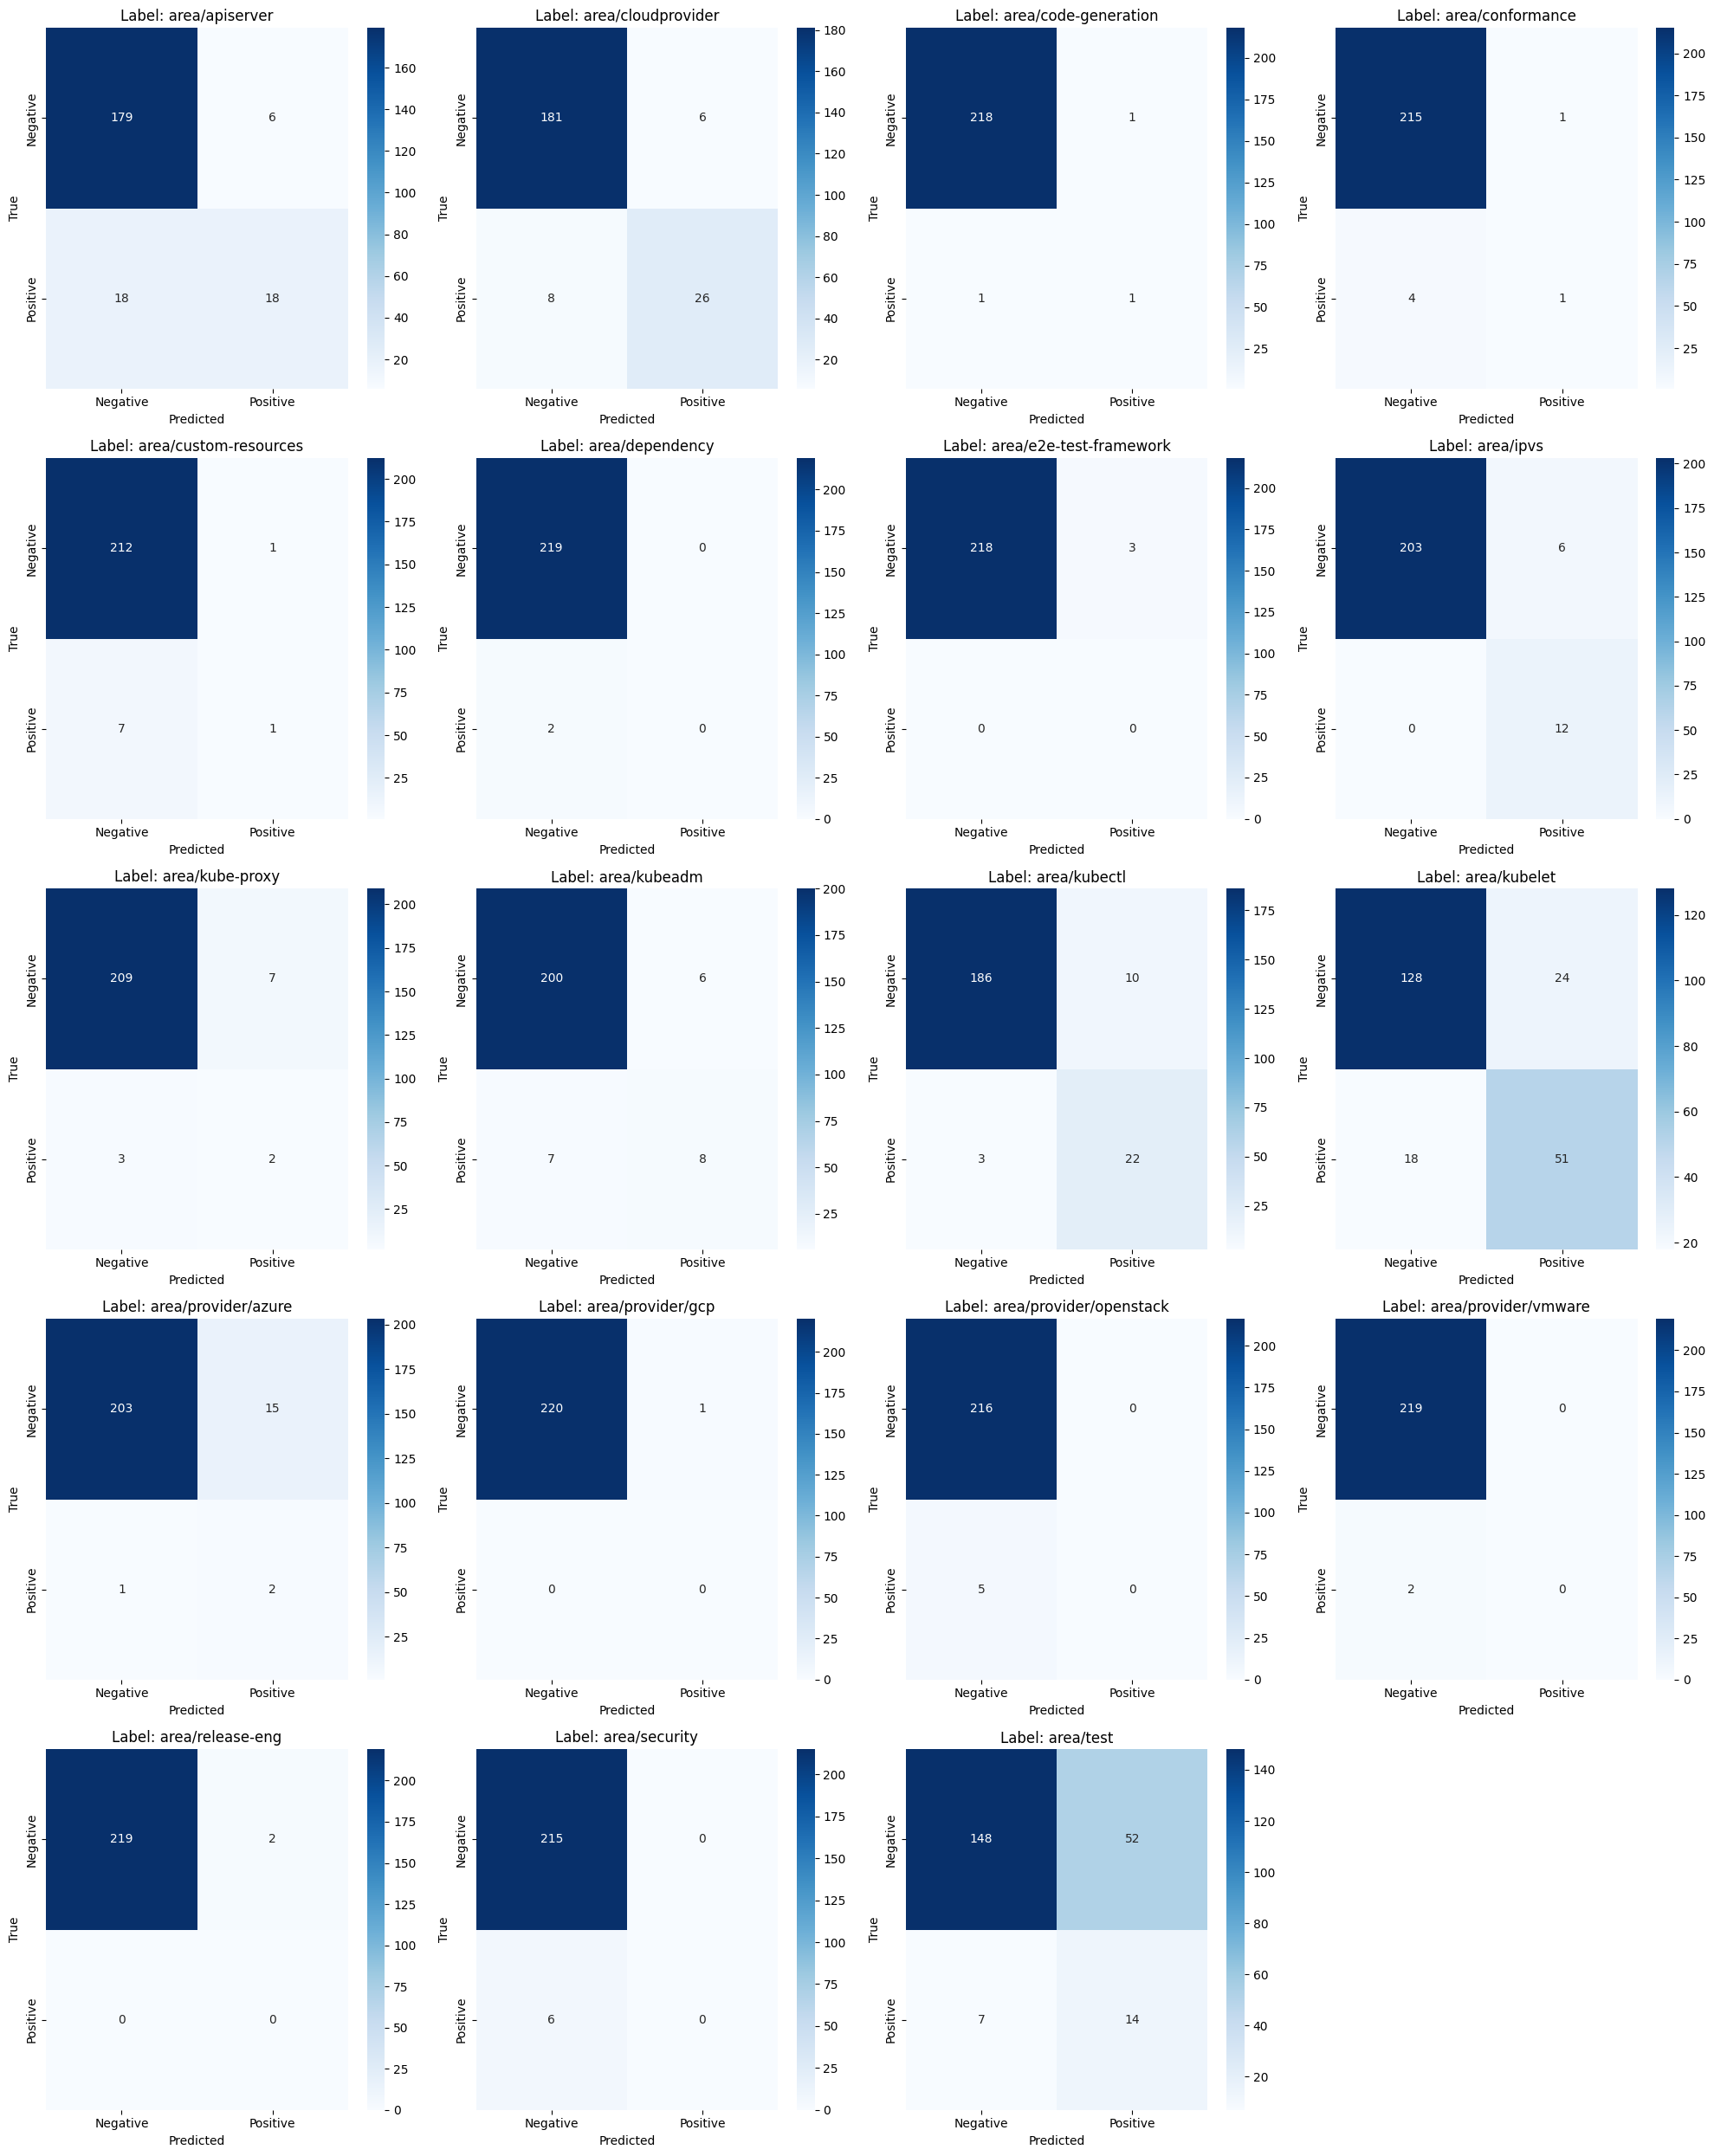

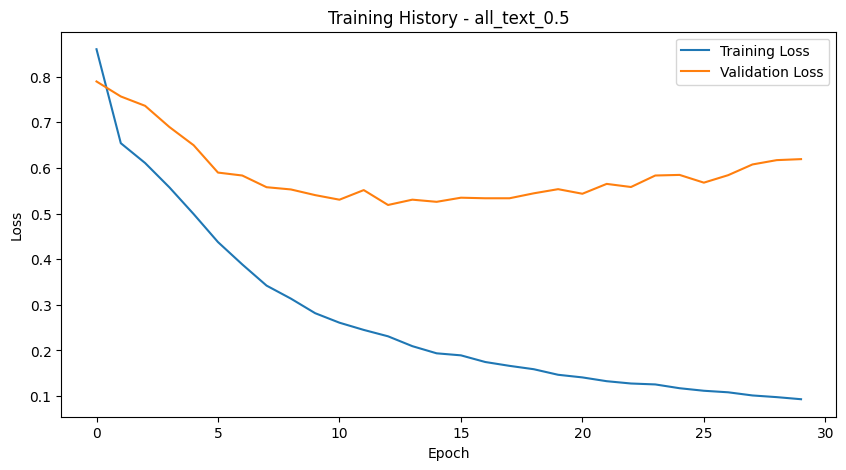

In [2]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-bug-data-comments-without-filenames/Bug Data with comments without changed files.csv",
                        help='Path to the data file (JSON or CSV format)')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=30, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', default=True,
                        help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true', 
                        help='Enable hybrid feature selection')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=10, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='count',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

# 0.6

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-bug-data-comments-without-filenames/Bug Data with comments without changed files.csv...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:04<00:00, 251.71it/s]


Token length statistics before filtering:
  Mean: 573.07, Std Dev: 876.51
  Min: 9, Max: 12403
  25th percentile: 150.00
  50th percentile (median): 305.00
  75th percentile: 639.50
Applied 3.0 std dev threshold: (1.00, 3202.61)
Removed 18 samples by std dev filtering (1.43% of data)
Total removed: 18 samples (1.43% of original data)
Remaining: 1240 samples (98.57% of original data)

Token length statistics after all filtering:
  Mean: 498.15, Std Dev: 542.43
  Min: 9, Max: 3199
  25th percentile: 148.00
  50th percentile (median): 299.00
  75th percentile: 621.25

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1240
Dataset size after basic cleaning: 1240 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1225 (98.79% of data)

Ste

Calculating token lengths: 100%|██████████| 1101/1101 [00:03<00:00, 336.16it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 3199
Mean token length: 491.17
Median token length: 283.00
Encoding labels...
Label density: 0.0634
Average labels per sample: 1.21
Feature selection enabled: False
Feature selection disabled
Feature selection disabled, using all labels
Training samples: 880, Validation samples: 221
Loading tokenizer...
Computing class weights for imbalanced labels...
Using larger batch size of 32 for 2 GPUs
Initializing model...
Model wrapped in DataParallel
Using weighted BCE loss
Starting training for 30 epochs...

Epoch 1/30


Training: 100%|██████████| 28/28 [00:43<00:00,  1.57s/it]


Train Loss: 0.8570, Train Accuracy (Exact Match): 0.0034
Val Loss: 0.7743
Val Accuracy (Exact Match): 0.0181
Val Accuracy (Partial Match): 0.1991
Val Accuracy (Jaccard): 0.1124
Val Precision: 0.1259, Val Recall: 0.1991, Val F1: 0.1493
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 2/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.50s/it]


Train Loss: 0.6531, Train Accuracy (Exact Match): 0.0318
Val Loss: 0.7550
Val Accuracy (Exact Match): 0.0226
Val Accuracy (Partial Match): 0.2828
Val Accuracy (Jaccard): 0.1281
Val Precision: 0.1429, Val Recall: 0.2828, Val F1: 0.1756
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 3/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.6124, Train Accuracy (Exact Match): 0.0750
Val Loss: 0.7334
Val Accuracy (Exact Match): 0.0136
Val Accuracy (Partial Match): 0.4932
Val Accuracy (Jaccard): 0.2014
Val Precision: 0.2085, Val Recall: 0.4932, Val F1: 0.2837
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 4/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.5618, Train Accuracy (Exact Match): 0.1068
Val Loss: 0.6939
Val Accuracy (Exact Match): 0.1086
Val Accuracy (Partial Match): 0.5452
Val Accuracy (Jaccard): 0.2859
Val Precision: 0.2969, Val Recall: 0.5452, Val F1: 0.3622
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 5/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.5061, Train Accuracy (Exact Match): 0.1659
Val Loss: 0.6608
Val Accuracy (Exact Match): 0.1584
Val Accuracy (Partial Match): 0.5158
Val Accuracy (Jaccard): 0.3205
Val Precision: 0.3375, Val Recall: 0.5158, Val F1: 0.3848
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 6/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.4526, Train Accuracy (Exact Match): 0.1943
Val Loss: 0.6009
Val Accuracy (Exact Match): 0.2036
Val Accuracy (Partial Match): 0.5814
Val Accuracy (Jaccard): 0.3824
Val Precision: 0.4016, Val Recall: 0.5814, Val F1: 0.4517
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 7/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.4010, Train Accuracy (Exact Match): 0.2557
Val Loss: 0.5844
Val Accuracy (Exact Match): 0.1900
Val Accuracy (Partial Match): 0.6063
Val Accuracy (Jaccard): 0.3913
Val Precision: 0.4177, Val Recall: 0.6063, Val F1: 0.4679
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 8/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.3519, Train Accuracy (Exact Match): 0.2989
Val Loss: 0.5547
Val Accuracy (Exact Match): 0.2217
Val Accuracy (Partial Match): 0.6425
Val Accuracy (Jaccard): 0.4232
Val Precision: 0.4465, Val Recall: 0.6425, Val F1: 0.4997
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 9/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.3225, Train Accuracy (Exact Match): 0.3182
Val Loss: 0.5472
Val Accuracy (Exact Match): 0.2353
Val Accuracy (Partial Match): 0.6516
Val Accuracy (Jaccard): 0.4284
Val Precision: 0.4465, Val Recall: 0.6516, Val F1: 0.5020
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 10/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.2912, Train Accuracy (Exact Match): 0.3716
Val Loss: 0.5397
Val Accuracy (Exact Match): 0.2262
Val Accuracy (Partial Match): 0.6719
Val Accuracy (Jaccard): 0.4303
Val Precision: 0.4464, Val Recall: 0.6719, Val F1: 0.5092
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 11/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.2656, Train Accuracy (Exact Match): 0.3977
Val Loss: 0.5300
Val Accuracy (Exact Match): 0.2443
Val Accuracy (Partial Match): 0.6833
Val Accuracy (Jaccard): 0.4518
Val Precision: 0.4732, Val Recall: 0.6833, Val F1: 0.5302
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 12/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.2514, Train Accuracy (Exact Match): 0.4284
Val Loss: 0.5434
Val Accuracy (Exact Match): 0.2262
Val Accuracy (Partial Match): 0.6538
Val Accuracy (Jaccard): 0.4400
Val Precision: 0.4630, Val Recall: 0.6538, Val F1: 0.5175

Epoch 13/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.2375, Train Accuracy (Exact Match): 0.4375
Val Loss: 0.5205
Val Accuracy (Exact Match): 0.2670
Val Accuracy (Partial Match): 0.6516
Val Accuracy (Jaccard): 0.4590
Val Precision: 0.4808, Val Recall: 0.6516, Val F1: 0.5287

Epoch 14/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.2141, Train Accuracy (Exact Match): 0.4943
Val Loss: 0.5312
Val Accuracy (Exact Match): 0.2896
Val Accuracy (Partial Match): 0.6584
Val Accuracy (Jaccard): 0.4800
Val Precision: 0.5030, Val Recall: 0.6584, Val F1: 0.5469
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 15/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1984, Train Accuracy (Exact Match): 0.5193
Val Loss: 0.5225
Val Accuracy (Exact Match): 0.2851
Val Accuracy (Partial Match): 0.6765
Val Accuracy (Jaccard): 0.4860
Val Precision: 0.5090, Val Recall: 0.6765, Val F1: 0.5567
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 16/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1923, Train Accuracy (Exact Match): 0.5000
Val Loss: 0.5210
Val Accuracy (Exact Match): 0.2624
Val Accuracy (Partial Match): 0.6697
Val Accuracy (Jaccard): 0.4655
Val Precision: 0.4847, Val Recall: 0.6697, Val F1: 0.5380

Epoch 17/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1767, Train Accuracy (Exact Match): 0.5318
Val Loss: 0.5262
Val Accuracy (Exact Match): 0.3122
Val Accuracy (Partial Match): 0.6787
Val Accuracy (Jaccard): 0.5004
Val Precision: 0.5211, Val Recall: 0.6787, Val F1: 0.5665
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 18/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1685, Train Accuracy (Exact Match): 0.5682
Val Loss: 0.5227
Val Accuracy (Exact Match): 0.3529
Val Accuracy (Partial Match): 0.6629
Val Accuracy (Jaccard): 0.5158
Val Precision: 0.5392, Val Recall: 0.6629, Val F1: 0.5730
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 19/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1634, Train Accuracy (Exact Match): 0.5523
Val Loss: 0.5394
Val Accuracy (Exact Match): 0.2986
Val Accuracy (Partial Match): 0.6652
Val Accuracy (Jaccard): 0.4902
Val Precision: 0.5128, Val Recall: 0.6652, Val F1: 0.5564

Epoch 20/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1501, Train Accuracy (Exact Match): 0.5977
Val Loss: 0.5384
Val Accuracy (Exact Match): 0.3348
Val Accuracy (Partial Match): 0.6674
Val Accuracy (Jaccard): 0.5109
Val Precision: 0.5358, Val Recall: 0.6674, Val F1: 0.5718

Epoch 21/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1435, Train Accuracy (Exact Match): 0.6330
Val Loss: 0.5387
Val Accuracy (Exact Match): 0.3484
Val Accuracy (Partial Match): 0.6674
Val Accuracy (Jaccard): 0.5173
Val Precision: 0.5464, Val Recall: 0.6674, Val F1: 0.5765
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 22/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1371, Train Accuracy (Exact Match): 0.6568
Val Loss: 0.5561
Val Accuracy (Exact Match): 0.2986
Val Accuracy (Partial Match): 0.6697
Val Accuracy (Jaccard): 0.4913
Val Precision: 0.5140, Val Recall: 0.6697, Val F1: 0.5582

Epoch 23/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1285, Train Accuracy (Exact Match): 0.6580
Val Loss: 0.5458
Val Accuracy (Exact Match): 0.3303
Val Accuracy (Partial Match): 0.6742
Val Accuracy (Jaccard): 0.5109
Val Precision: 0.5381, Val Recall: 0.6742, Val F1: 0.5741

Epoch 24/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1262, Train Accuracy (Exact Match): 0.6636
Val Loss: 0.5752
Val Accuracy (Exact Match): 0.2579
Val Accuracy (Partial Match): 0.6425
Val Accuracy (Jaccard): 0.4572
Val Precision: 0.4798, Val Recall: 0.6425, Val F1: 0.5261

Epoch 25/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1207, Train Accuracy (Exact Match): 0.6670
Val Loss: 0.5699
Val Accuracy (Exact Match): 0.3122
Val Accuracy (Partial Match): 0.6765
Val Accuracy (Jaccard): 0.5015
Val Precision: 0.5264, Val Recall: 0.6765, Val F1: 0.5677

Epoch 26/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1159, Train Accuracy (Exact Match): 0.6841
Val Loss: 0.5608
Val Accuracy (Exact Match): 0.3529
Val Accuracy (Partial Match): 0.6493
Val Accuracy (Jaccard): 0.5109
Val Precision: 0.5388, Val Recall: 0.6493, Val F1: 0.5658

Epoch 27/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1066, Train Accuracy (Exact Match): 0.7250
Val Loss: 0.5728
Val Accuracy (Exact Match): 0.3032
Val Accuracy (Partial Match): 0.6448
Val Accuracy (Jaccard): 0.4838
Val Precision: 0.5102, Val Recall: 0.6448, Val F1: 0.5462

Epoch 28/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1010, Train Accuracy (Exact Match): 0.7409
Val Loss: 0.5946
Val Accuracy (Exact Match): 0.3439
Val Accuracy (Partial Match): 0.6787
Val Accuracy (Jaccard): 0.5211
Val Precision: 0.5468, Val Recall: 0.6787, Val F1: 0.5819
Saved new best model to ./results/run_20250517_092635_all_text_0.6/best_model_all_text_0.6.pt

Epoch 29/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.0997, Train Accuracy (Exact Match): 0.7455
Val Loss: 0.6098
Val Accuracy (Exact Match): 0.3348
Val Accuracy (Partial Match): 0.6561
Val Accuracy (Jaccard): 0.5034
Val Precision: 0.5245, Val Recall: 0.6561, Val F1: 0.5612

Epoch 30/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.0950, Train Accuracy (Exact Match): 0.7670
Val Loss: 0.6062
Val Accuracy (Exact Match): 0.3167
Val Accuracy (Partial Match): 0.6606
Val Accuracy (Jaccard): 0.4970
Val Precision: 0.5181, Val Recall: 0.6606, Val F1: 0.5594

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.3439
Partial Match Accuracy: 0.6787
Jaccard Similarity: 0.5211
Precision: 0.5468
Recall: 0.6787
F1 Score: 0.5819

Training completed! Results saved to ./results/run_20250517_092635_all_text_0.6


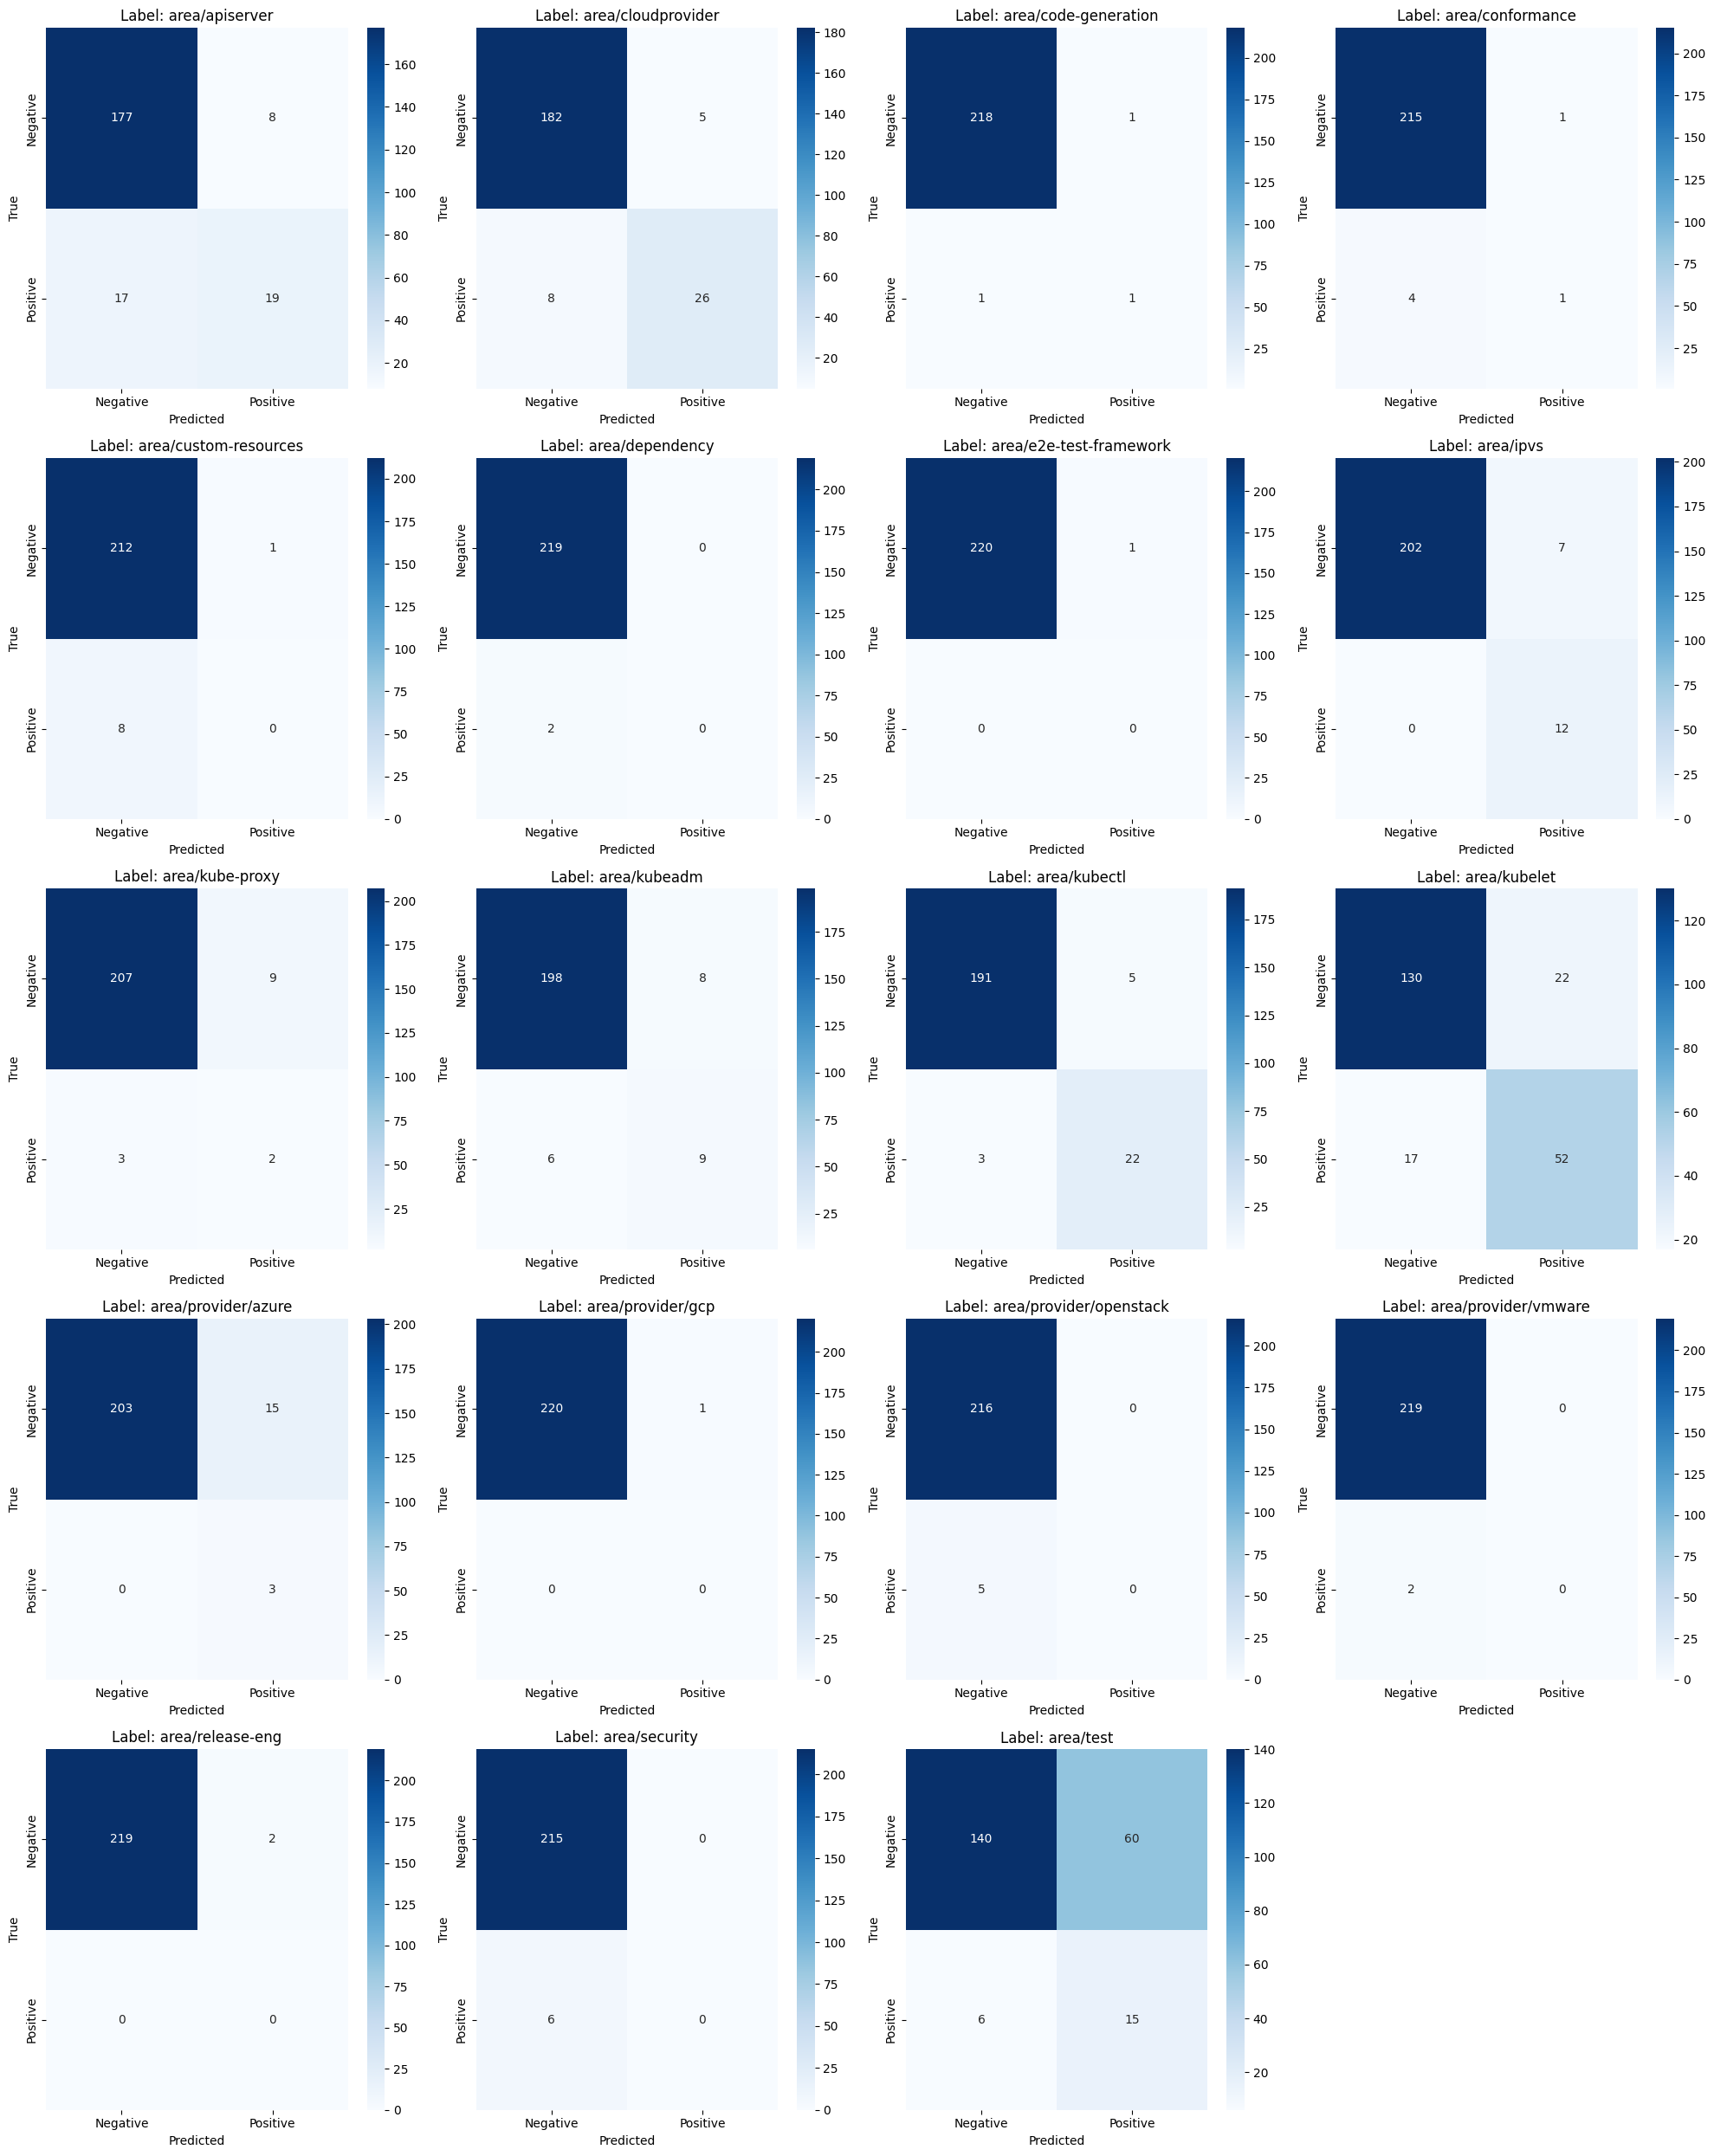

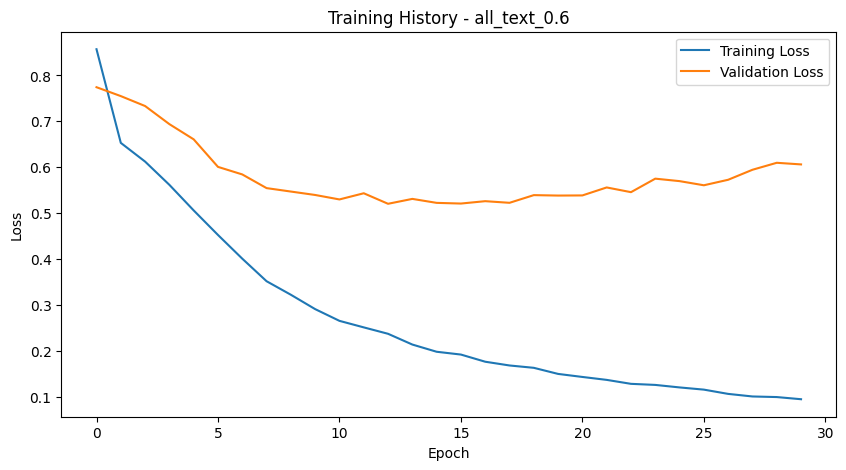

In [3]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-bug-data-comments-without-filenames/Bug Data with comments without changed files.csv",
                        help='Path to the data file (JSON or CSV format)')
    parser.add_argument('--text_column', type=str, default='all_text_0.6',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=30, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', default=True,
                        help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true', 
                        help='Enable hybrid feature selection')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=10, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='count',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

# 0.7

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-bug-data-comments-without-filenames/Bug Data with comments without changed files.csv...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:05<00:00, 244.97it/s]


Token length statistics before filtering:
  Mean: 594.69, Std Dev: 888.65
  Min: 9, Max: 12580
  25th percentile: 163.00
  50th percentile (median): 322.00
  75th percentile: 675.00
Applied 3.0 std dev threshold: (1.00, 3260.64)
Removed 19 samples by std dev filtering (1.51% of data)
Total removed: 19 samples (1.51% of original data)
Remaining: 1239 samples (98.49% of original data)

Token length statistics after all filtering:
  Mean: 516.60, Std Dev: 546.16
  Min: 9, Max: 3250
  25th percentile: 160.50
  50th percentile (median): 316.00
  75th percentile: 646.50

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1239
Dataset size after basic cleaning: 1239 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1224 (98.79% of data)

Ste

Calculating token lengths: 100%|██████████| 1100/1100 [00:03<00:00, 323.14it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 3092
Mean token length: 509.14
Median token length: 300.00
Encoding labels...
Label density: 0.0634
Average labels per sample: 1.20
Feature selection enabled: False
Feature selection disabled
Feature selection disabled, using all labels
Training samples: 880, Validation samples: 220
Loading tokenizer...
Computing class weights for imbalanced labels...
Using larger batch size of 32 for 2 GPUs
Initializing model...
Model wrapped in DataParallel
Using weighted BCE loss
Starting training for 30 epochs...

Epoch 1/30


Training: 100%|██████████| 28/28 [00:44<00:00,  1.57s/it]


Train Loss: 0.8625, Train Accuracy (Exact Match): 0.0034
Val Loss: 0.7973
Val Accuracy (Exact Match): 0.0136
Val Accuracy (Partial Match): 0.1909
Val Accuracy (Jaccard): 0.1023
Val Precision: 0.1148, Val Recall: 0.1909, Val F1: 0.1383
Saved new best model to ./results/run_20250517_095226_all_text_0.7/best_model_all_text_0.7.pt

Epoch 2/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.50s/it]


Train Loss: 0.6640, Train Accuracy (Exact Match): 0.0250
Val Loss: 0.7649
Val Accuracy (Exact Match): 0.0091
Val Accuracy (Partial Match): 0.3273
Val Accuracy (Jaccard): 0.1284
Val Precision: 0.1345, Val Recall: 0.3273, Val F1: 0.1844
Saved new best model to ./results/run_20250517_095226_all_text_0.7/best_model_all_text_0.7.pt

Epoch 3/30


Training: 100%|██████████| 28/28 [00:43<00:00,  1.54s/it]


Train Loss: 0.6185, Train Accuracy (Exact Match): 0.0545
Val Loss: 0.7409
Val Accuracy (Exact Match): 0.0136
Val Accuracy (Partial Match): 0.4500
Val Accuracy (Jaccard): 0.1948
Val Precision: 0.2009, Val Recall: 0.4500, Val F1: 0.2703
Saved new best model to ./results/run_20250517_095226_all_text_0.7/best_model_all_text_0.7.pt

Epoch 4/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.5693, Train Accuracy (Exact Match): 0.1023
Val Loss: 0.6897
Val Accuracy (Exact Match): 0.1409
Val Accuracy (Partial Match): 0.5523
Val Accuracy (Jaccard): 0.3323
Val Precision: 0.3439, Val Recall: 0.5523, Val F1: 0.4055
Saved new best model to ./results/run_20250517_095226_all_text_0.7/best_model_all_text_0.7.pt

Epoch 5/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.5138, Train Accuracy (Exact Match): 0.1386
Val Loss: 0.6450
Val Accuracy (Exact Match): 0.1500
Val Accuracy (Partial Match): 0.5636
Val Accuracy (Jaccard): 0.3511
Val Precision: 0.3689, Val Recall: 0.5636, Val F1: 0.4244
Saved new best model to ./results/run_20250517_095226_all_text_0.7/best_model_all_text_0.7.pt

Epoch 6/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.4555, Train Accuracy (Exact Match): 0.1955
Val Loss: 0.6126
Val Accuracy (Exact Match): 0.1455
Val Accuracy (Partial Match): 0.6409
Val Accuracy (Jaccard): 0.3840
Val Precision: 0.3973, Val Recall: 0.6409, Val F1: 0.4712
Saved new best model to ./results/run_20250517_095226_all_text_0.7/best_model_all_text_0.7.pt

Epoch 7/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.3946, Train Accuracy (Exact Match): 0.2750
Val Loss: 0.5708
Val Accuracy (Exact Match): 0.1909
Val Accuracy (Partial Match): 0.6750
Val Accuracy (Jaccard): 0.4286
Val Precision: 0.4477, Val Recall: 0.6750, Val F1: 0.5144
Saved new best model to ./results/run_20250517_095226_all_text_0.7/best_model_all_text_0.7.pt

Epoch 8/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.3497, Train Accuracy (Exact Match): 0.3273
Val Loss: 0.5553
Val Accuracy (Exact Match): 0.2455
Val Accuracy (Partial Match): 0.6977
Val Accuracy (Jaccard): 0.4712
Val Precision: 0.4894, Val Recall: 0.6977, Val F1: 0.5520
Saved new best model to ./results/run_20250517_095226_all_text_0.7/best_model_all_text_0.7.pt

Epoch 9/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.3155, Train Accuracy (Exact Match): 0.3307
Val Loss: 0.5480
Val Accuracy (Exact Match): 0.1955
Val Accuracy (Partial Match): 0.6545
Val Accuracy (Jaccard): 0.4235
Val Precision: 0.4436, Val Recall: 0.6545, Val F1: 0.5058

Epoch 10/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.2872, Train Accuracy (Exact Match): 0.3852
Val Loss: 0.5306
Val Accuracy (Exact Match): 0.2955
Val Accuracy (Partial Match): 0.6614
Val Accuracy (Jaccard): 0.4799
Val Precision: 0.5008, Val Recall: 0.6614, Val F1: 0.5464

Epoch 11/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.2651, Train Accuracy (Exact Match): 0.3955
Val Loss: 0.5360
Val Accuracy (Exact Match): 0.2545
Val Accuracy (Partial Match): 0.6818
Val Accuracy (Jaccard): 0.4723
Val Precision: 0.4917, Val Recall: 0.6818, Val F1: 0.5495

Epoch 12/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.2445, Train Accuracy (Exact Match): 0.4205
Val Loss: 0.5335
Val Accuracy (Exact Match): 0.3000
Val Accuracy (Partial Match): 0.6773
Val Accuracy (Jaccard): 0.4936
Val Precision: 0.5186, Val Recall: 0.6773, Val F1: 0.5623
Saved new best model to ./results/run_20250517_095226_all_text_0.7/best_model_all_text_0.7.pt

Epoch 13/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.2275, Train Accuracy (Exact Match): 0.4591
Val Loss: 0.5228
Val Accuracy (Exact Match): 0.2818
Val Accuracy (Partial Match): 0.6818
Val Accuracy (Jaccard): 0.4871
Val Precision: 0.5091, Val Recall: 0.6818, Val F1: 0.5595

Epoch 14/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.2127, Train Accuracy (Exact Match): 0.4864
Val Loss: 0.5340
Val Accuracy (Exact Match): 0.3091
Val Accuracy (Partial Match): 0.6841
Val Accuracy (Jaccard): 0.5000
Val Precision: 0.5242, Val Recall: 0.6841, Val F1: 0.5680
Saved new best model to ./results/run_20250517_095226_all_text_0.7/best_model_all_text_0.7.pt

Epoch 15/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.2012, Train Accuracy (Exact Match): 0.4784
Val Loss: 0.5151
Val Accuracy (Exact Match): 0.3364
Val Accuracy (Partial Match): 0.7023
Val Accuracy (Jaccard): 0.5235
Val Precision: 0.5477, Val Recall: 0.7023, Val F1: 0.5898
Saved new best model to ./results/run_20250517_095226_all_text_0.7/best_model_all_text_0.7.pt

Epoch 16/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1904, Train Accuracy (Exact Match): 0.5409
Val Loss: 0.5214
Val Accuracy (Exact Match): 0.2682
Val Accuracy (Partial Match): 0.6818
Val Accuracy (Jaccard): 0.4795
Val Precision: 0.5030, Val Recall: 0.6818, Val F1: 0.5542

Epoch 17/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1758, Train Accuracy (Exact Match): 0.5375
Val Loss: 0.5291
Val Accuracy (Exact Match): 0.2909
Val Accuracy (Partial Match): 0.6864
Val Accuracy (Jaccard): 0.4932
Val Precision: 0.5136, Val Recall: 0.6864, Val F1: 0.5641

Epoch 18/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1643, Train Accuracy (Exact Match): 0.5773
Val Loss: 0.5329
Val Accuracy (Exact Match): 0.3455
Val Accuracy (Partial Match): 0.6795
Val Accuracy (Jaccard): 0.5167
Val Precision: 0.5379, Val Recall: 0.6795, Val F1: 0.5770

Epoch 19/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1598, Train Accuracy (Exact Match): 0.5886
Val Loss: 0.5264
Val Accuracy (Exact Match): 0.3318
Val Accuracy (Partial Match): 0.6773
Val Accuracy (Jaccard): 0.5087
Val Precision: 0.5311, Val Recall: 0.6773, Val F1: 0.5714

Epoch 20/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1498, Train Accuracy (Exact Match): 0.5943
Val Loss: 0.5435
Val Accuracy (Exact Match): 0.3273
Val Accuracy (Partial Match): 0.6773
Val Accuracy (Jaccard): 0.5102
Val Precision: 0.5341, Val Recall: 0.6773, Val F1: 0.5736

Epoch 21/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1422, Train Accuracy (Exact Match): 0.6125
Val Loss: 0.5390
Val Accuracy (Exact Match): 0.3409
Val Accuracy (Partial Match): 0.7000
Val Accuracy (Jaccard): 0.5295
Val Precision: 0.5545, Val Recall: 0.7000, Val F1: 0.5952
Saved new best model to ./results/run_20250517_095226_all_text_0.7/best_model_all_text_0.7.pt

Epoch 22/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1364, Train Accuracy (Exact Match): 0.6341
Val Loss: 0.5390
Val Accuracy (Exact Match): 0.3455
Val Accuracy (Partial Match): 0.6773
Val Accuracy (Jaccard): 0.5205
Val Precision: 0.5455, Val Recall: 0.6773, Val F1: 0.5815

Epoch 23/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.1333, Train Accuracy (Exact Match): 0.6307
Val Loss: 0.5504
Val Accuracy (Exact Match): 0.3545
Val Accuracy (Partial Match): 0.6841
Val Accuracy (Jaccard): 0.5277
Val Precision: 0.5538, Val Recall: 0.6841, Val F1: 0.5880

Epoch 24/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1248, Train Accuracy (Exact Match): 0.6352
Val Loss: 0.5544
Val Accuracy (Exact Match): 0.3636
Val Accuracy (Partial Match): 0.6727
Val Accuracy (Jaccard): 0.5269
Val Precision: 0.5481, Val Recall: 0.6727, Val F1: 0.5835

Epoch 25/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1200, Train Accuracy (Exact Match): 0.6727
Val Loss: 0.5512
Val Accuracy (Exact Match): 0.3909
Val Accuracy (Partial Match): 0.6841
Val Accuracy (Jaccard): 0.5489
Val Precision: 0.5735, Val Recall: 0.6841, Val F1: 0.6032
Saved new best model to ./results/run_20250517_095226_all_text_0.7/best_model_all_text_0.7.pt

Epoch 26/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1140, Train Accuracy (Exact Match): 0.7205
Val Loss: 0.5559
Val Accuracy (Exact Match): 0.3727
Val Accuracy (Partial Match): 0.6750
Val Accuracy (Jaccard): 0.5360
Val Precision: 0.5606, Val Recall: 0.6750, Val F1: 0.5918

Epoch 27/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1122, Train Accuracy (Exact Match): 0.6966
Val Loss: 0.5769
Val Accuracy (Exact Match): 0.3136
Val Accuracy (Partial Match): 0.6614
Val Accuracy (Jaccard): 0.4970
Val Precision: 0.5174, Val Recall: 0.6614, Val F1: 0.5605

Epoch 28/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1057, Train Accuracy (Exact Match): 0.7114
Val Loss: 0.5768
Val Accuracy (Exact Match): 0.3455
Val Accuracy (Partial Match): 0.6682
Val Accuracy (Jaccard): 0.5182
Val Precision: 0.5394, Val Recall: 0.6682, Val F1: 0.5771

Epoch 29/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.0998, Train Accuracy (Exact Match): 0.7500
Val Loss: 0.5984
Val Accuracy (Exact Match): 0.3091
Val Accuracy (Partial Match): 0.6682
Val Accuracy (Jaccard): 0.4985
Val Precision: 0.5182, Val Recall: 0.6682, Val F1: 0.5635

Epoch 30/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.0966, Train Accuracy (Exact Match): 0.7443
Val Loss: 0.5846
Val Accuracy (Exact Match): 0.3773
Val Accuracy (Partial Match): 0.6705
Val Accuracy (Jaccard): 0.5356
Val Precision: 0.5606, Val Recall: 0.6705, Val F1: 0.5900

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.3909
Partial Match Accuracy: 0.6841
Jaccard Similarity: 0.5489
Precision: 0.5735
Recall: 0.6841
F1 Score: 0.6032

Training completed! Results saved to ./results/run_20250517_095226_all_text_0.7


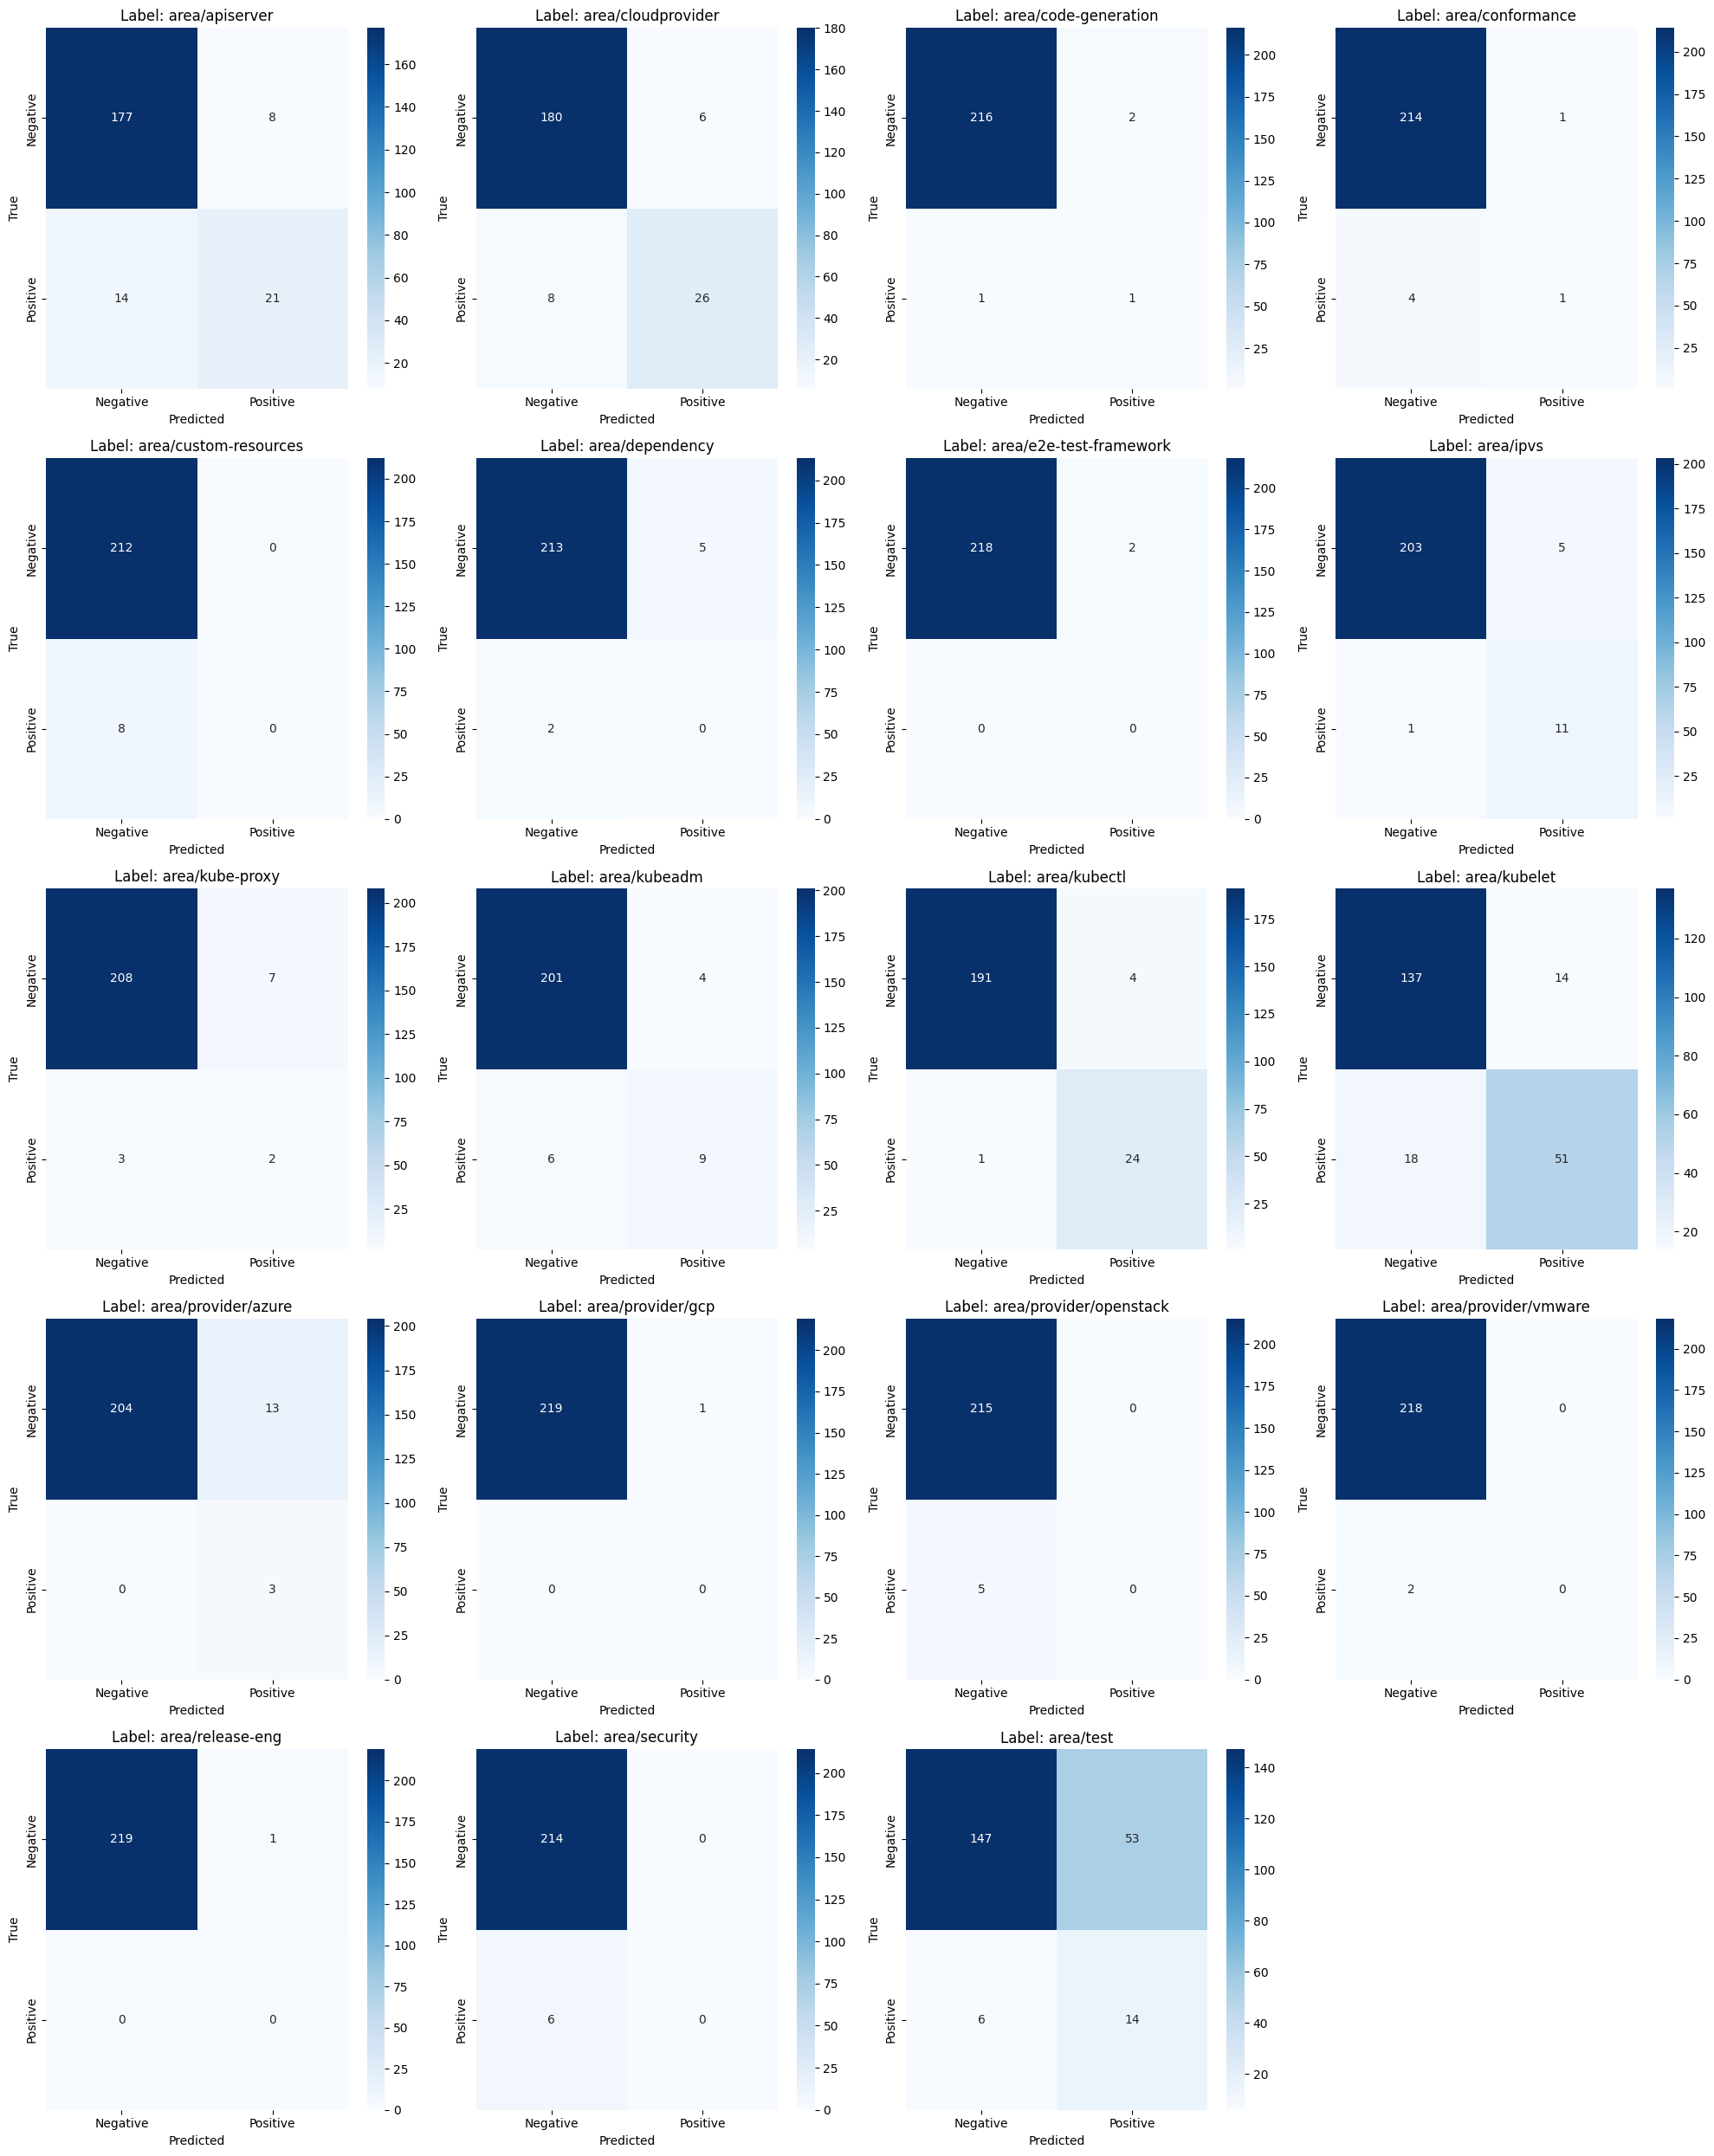

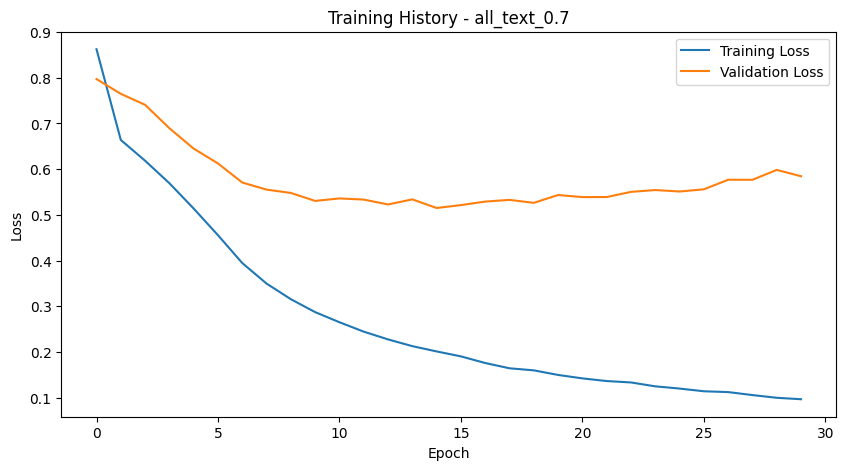

In [4]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-bug-data-comments-without-filenames/Bug Data with comments without changed files.csv",
                        help='Path to the data file (JSON or CSV format)')
    parser.add_argument('--text_column', type=str, default='all_text_0.7',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=30, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', default=True,
                        help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true', 
                        help='Enable hybrid feature selection')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=10, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='count',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

# 0.8

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-bug-data-comments-without-filenames/Bug Data with comments without changed files.csv...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:05<00:00, 234.76it/s]


Token length statistics before filtering:
  Mean: 612.51, Std Dev: 896.75
  Min: 9, Max: 12602
  25th percentile: 174.00
  50th percentile (median): 335.50
  75th percentile: 698.00
Applied 3.0 std dev threshold: (1.00, 3302.76)
Removed 19 samples by std dev filtering (1.51% of data)
Total removed: 19 samples (1.51% of original data)
Remaining: 1239 samples (98.49% of original data)

Token length statistics after all filtering:
  Mean: 533.81, Std Dev: 553.84
  Min: 9, Max: 3295
  25th percentile: 171.50
  50th percentile (median): 328.00
  75th percentile: 660.50

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1239
Dataset size after basic cleaning: 1239 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1224 (98.79% of data)

Ste

Calculating token lengths: 100%|██████████| 1100/1100 [00:03<00:00, 315.32it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 3105
Mean token length: 526.16
Median token length: 313.50
Encoding labels...
Label density: 0.0634
Average labels per sample: 1.20
Feature selection enabled: False
Feature selection disabled
Feature selection disabled, using all labels
Training samples: 880, Validation samples: 220
Loading tokenizer...
Computing class weights for imbalanced labels...
Using larger batch size of 32 for 2 GPUs
Initializing model...
Model wrapped in DataParallel
Using weighted BCE loss
Starting training for 30 epochs...

Epoch 1/30


Training: 100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


Train Loss: 0.8639, Train Accuracy (Exact Match): 0.0034
Val Loss: 0.8012
Val Accuracy (Exact Match): 0.0136
Val Accuracy (Partial Match): 0.1955
Val Accuracy (Jaccard): 0.1057
Val Precision: 0.1189, Val Recall: 0.1955, Val F1: 0.1427
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 2/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.6662, Train Accuracy (Exact Match): 0.0261
Val Loss: 0.7618
Val Accuracy (Exact Match): 0.0091
Val Accuracy (Partial Match): 0.3864
Val Accuracy (Jaccard): 0.1361
Val Precision: 0.1420, Val Recall: 0.3864, Val F1: 0.2007
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 3/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.6144, Train Accuracy (Exact Match): 0.0659
Val Loss: 0.7321
Val Accuracy (Exact Match): 0.0273
Val Accuracy (Partial Match): 0.4432
Val Accuracy (Jaccard): 0.2073
Val Precision: 0.2133, Val Recall: 0.4432, Val F1: 0.2797
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 4/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.5588, Train Accuracy (Exact Match): 0.1114
Val Loss: 0.6781
Val Accuracy (Exact Match): 0.1455
Val Accuracy (Partial Match): 0.5295
Val Accuracy (Jaccard): 0.3299
Val Precision: 0.3436, Val Recall: 0.5295, Val F1: 0.3985
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 5/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.4924, Train Accuracy (Exact Match): 0.1818
Val Loss: 0.6189
Val Accuracy (Exact Match): 0.1273
Val Accuracy (Partial Match): 0.5795
Val Accuracy (Jaccard): 0.3572
Val Precision: 0.3811, Val Recall: 0.5795, Val F1: 0.4388
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 6/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.4311, Train Accuracy (Exact Match): 0.2500
Val Loss: 0.5838
Val Accuracy (Exact Match): 0.1500
Val Accuracy (Partial Match): 0.6636
Val Accuracy (Jaccard): 0.4017
Val Precision: 0.4212, Val Recall: 0.6636, Val F1: 0.4935
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 7/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.3787, Train Accuracy (Exact Match): 0.2830
Val Loss: 0.5477
Val Accuracy (Exact Match): 0.1727
Val Accuracy (Partial Match): 0.6614
Val Accuracy (Jaccard): 0.4168
Val Precision: 0.4390, Val Recall: 0.6614, Val F1: 0.5050
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 8/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.3376, Train Accuracy (Exact Match): 0.3295
Val Loss: 0.5368
Val Accuracy (Exact Match): 0.2727
Val Accuracy (Partial Match): 0.7182
Val Accuracy (Jaccard): 0.4966
Val Precision: 0.5133, Val Recall: 0.7182, Val F1: 0.5764
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 9/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.3025, Train Accuracy (Exact Match): 0.3568
Val Loss: 0.5249
Val Accuracy (Exact Match): 0.1864
Val Accuracy (Partial Match): 0.6682
Val Accuracy (Jaccard): 0.4212
Val Precision: 0.4364, Val Recall: 0.6682, Val F1: 0.5073

Epoch 10/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.2739, Train Accuracy (Exact Match): 0.3841
Val Loss: 0.5011
Val Accuracy (Exact Match): 0.3455
Val Accuracy (Partial Match): 0.7068
Val Accuracy (Jaccard): 0.5254
Val Precision: 0.5443, Val Recall: 0.7068, Val F1: 0.5917
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 11/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.2549, Train Accuracy (Exact Match): 0.4148
Val Loss: 0.5128
Val Accuracy (Exact Match): 0.2545
Val Accuracy (Partial Match): 0.7023
Val Accuracy (Jaccard): 0.4818
Val Precision: 0.5000, Val Recall: 0.7023, Val F1: 0.5627

Epoch 12/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.2344, Train Accuracy (Exact Match): 0.4534
Val Loss: 0.5160
Val Accuracy (Exact Match): 0.2773
Val Accuracy (Partial Match): 0.6932
Val Accuracy (Jaccard): 0.4860
Val Precision: 0.5023, Val Recall: 0.6932, Val F1: 0.5608

Epoch 13/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.2224, Train Accuracy (Exact Match): 0.4591
Val Loss: 0.5083
Val Accuracy (Exact Match): 0.2591
Val Accuracy (Partial Match): 0.7091
Val Accuracy (Jaccard): 0.4867
Val Precision: 0.5053, Val Recall: 0.7091, Val F1: 0.5674

Epoch 14/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.2026, Train Accuracy (Exact Match): 0.5011
Val Loss: 0.5171
Val Accuracy (Exact Match): 0.3227
Val Accuracy (Partial Match): 0.7159
Val Accuracy (Jaccard): 0.5212
Val Precision: 0.5386, Val Recall: 0.7159, Val F1: 0.5921
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 15/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1942, Train Accuracy (Exact Match): 0.4943
Val Loss: 0.5012
Val Accuracy (Exact Match): 0.3591
Val Accuracy (Partial Match): 0.7091
Val Accuracy (Jaccard): 0.5360
Val Precision: 0.5530, Val Recall: 0.7091, Val F1: 0.5992
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 16/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1803, Train Accuracy (Exact Match): 0.5693
Val Loss: 0.5034
Val Accuracy (Exact Match): 0.3364
Val Accuracy (Partial Match): 0.7045
Val Accuracy (Jaccard): 0.5233
Val Precision: 0.5420, Val Recall: 0.7045, Val F1: 0.5903

Epoch 17/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1723, Train Accuracy (Exact Match): 0.5545
Val Loss: 0.5134
Val Accuracy (Exact Match): 0.2682
Val Accuracy (Partial Match): 0.7136
Val Accuracy (Jaccard): 0.4939
Val Precision: 0.5155, Val Recall: 0.7136, Val F1: 0.5738

Epoch 18/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1591, Train Accuracy (Exact Match): 0.5818
Val Loss: 0.5252
Val Accuracy (Exact Match): 0.3773
Val Accuracy (Partial Match): 0.7045
Val Accuracy (Jaccard): 0.5424
Val Precision: 0.5583, Val Recall: 0.7045, Val F1: 0.6012
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 19/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1553, Train Accuracy (Exact Match): 0.5739
Val Loss: 0.5102
Val Accuracy (Exact Match): 0.4136
Val Accuracy (Partial Match): 0.7000
Val Accuracy (Jaccard): 0.5587
Val Precision: 0.5761, Val Recall: 0.7000, Val F1: 0.6114
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 20/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1446, Train Accuracy (Exact Match): 0.6136
Val Loss: 0.5273
Val Accuracy (Exact Match): 0.3636
Val Accuracy (Partial Match): 0.7023
Val Accuracy (Jaccard): 0.5371
Val Precision: 0.5587, Val Recall: 0.7023, Val F1: 0.5982

Epoch 21/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1384, Train Accuracy (Exact Match): 0.6068
Val Loss: 0.5243
Val Accuracy (Exact Match): 0.3682
Val Accuracy (Partial Match): 0.7045
Val Accuracy (Jaccard): 0.5447
Val Precision: 0.5682, Val Recall: 0.7045, Val F1: 0.6065

Epoch 22/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1322, Train Accuracy (Exact Match): 0.6398
Val Loss: 0.5354
Val Accuracy (Exact Match): 0.3773
Val Accuracy (Partial Match): 0.7023
Val Accuracy (Jaccard): 0.5462
Val Precision: 0.5659, Val Recall: 0.7023, Val F1: 0.6050

Epoch 23/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1285, Train Accuracy (Exact Match): 0.6557
Val Loss: 0.5402
Val Accuracy (Exact Match): 0.3955
Val Accuracy (Partial Match): 0.7023
Val Accuracy (Jaccard): 0.5576
Val Precision: 0.5803, Val Recall: 0.7023, Val F1: 0.6141
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 24/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.1203, Train Accuracy (Exact Match): 0.6625
Val Loss: 0.5447
Val Accuracy (Exact Match): 0.3318
Val Accuracy (Partial Match): 0.7000
Val Accuracy (Jaccard): 0.5265
Val Precision: 0.5492, Val Recall: 0.7000, Val F1: 0.5930

Epoch 25/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1157, Train Accuracy (Exact Match): 0.6784
Val Loss: 0.5447
Val Accuracy (Exact Match): 0.4227
Val Accuracy (Partial Match): 0.6977
Val Accuracy (Jaccard): 0.5723
Val Precision: 0.5970, Val Recall: 0.6977, Val F1: 0.6236
Saved new best model to ./results/run_20250517_101816_all_text_0.8/best_model_all_text_0.8.pt

Epoch 26/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1110, Train Accuracy (Exact Match): 0.6898
Val Loss: 0.5478
Val Accuracy (Exact Match): 0.4091
Val Accuracy (Partial Match): 0.7000
Val Accuracy (Jaccard): 0.5629
Val Precision: 0.5833, Val Recall: 0.7000, Val F1: 0.6164

Epoch 27/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1050, Train Accuracy (Exact Match): 0.7159
Val Loss: 0.5654
Val Accuracy (Exact Match): 0.3045
Val Accuracy (Partial Match): 0.7045
Val Accuracy (Jaccard): 0.5152
Val Precision: 0.5379, Val Recall: 0.7045, Val F1: 0.5868

Epoch 28/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1012, Train Accuracy (Exact Match): 0.7273
Val Loss: 0.5664
Val Accuracy (Exact Match): 0.3727
Val Accuracy (Partial Match): 0.7000
Val Accuracy (Jaccard): 0.5436
Val Precision: 0.5629, Val Recall: 0.7000, Val F1: 0.6024

Epoch 29/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.0943, Train Accuracy (Exact Match): 0.7682
Val Loss: 0.5855
Val Accuracy (Exact Match): 0.3318
Val Accuracy (Partial Match): 0.6886
Val Accuracy (Jaccard): 0.5220
Val Precision: 0.5439, Val Recall: 0.6886, Val F1: 0.5861

Epoch 30/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.0940, Train Accuracy (Exact Match): 0.7307
Val Loss: 0.5811
Val Accuracy (Exact Match): 0.3727
Val Accuracy (Partial Match): 0.6955
Val Accuracy (Jaccard): 0.5447
Val Precision: 0.5659, Val Recall: 0.6955, Val F1: 0.6027

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4227
Partial Match Accuracy: 0.6977
Jaccard Similarity: 0.5723
Precision: 0.5970
Recall: 0.6977
F1 Score: 0.6236

Training completed! Results saved to ./results/run_20250517_101816_all_text_0.8


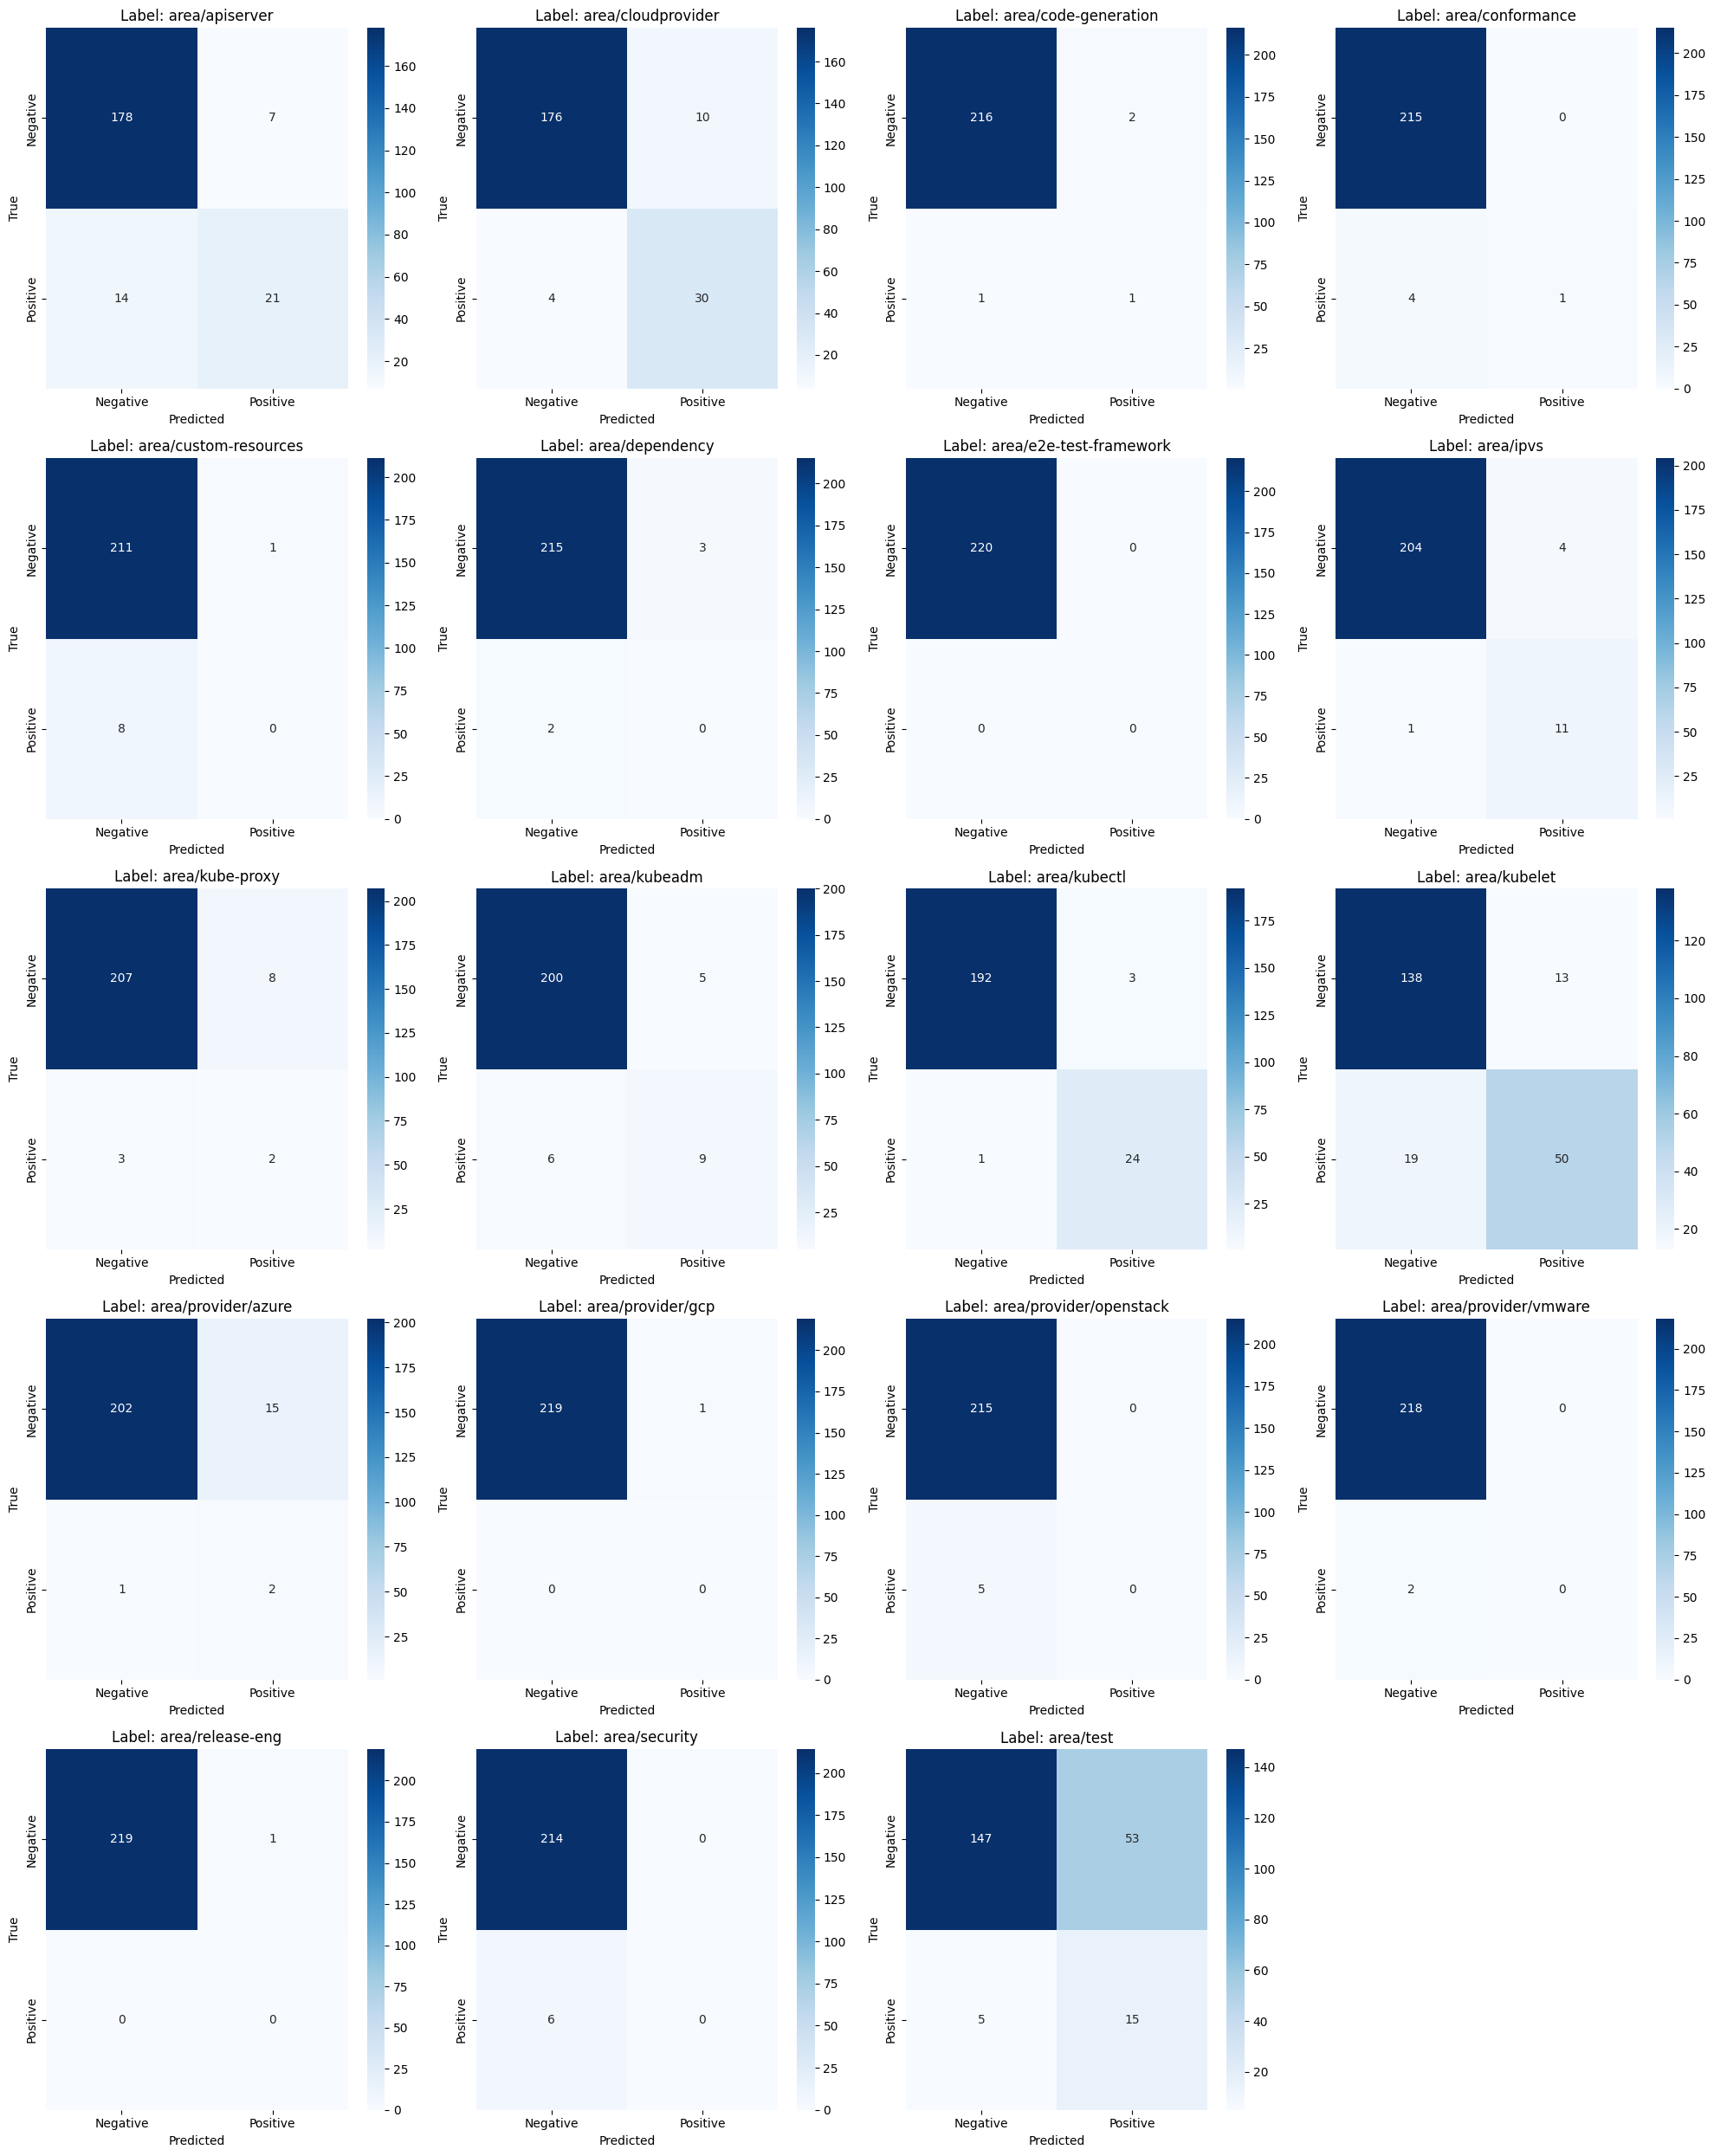

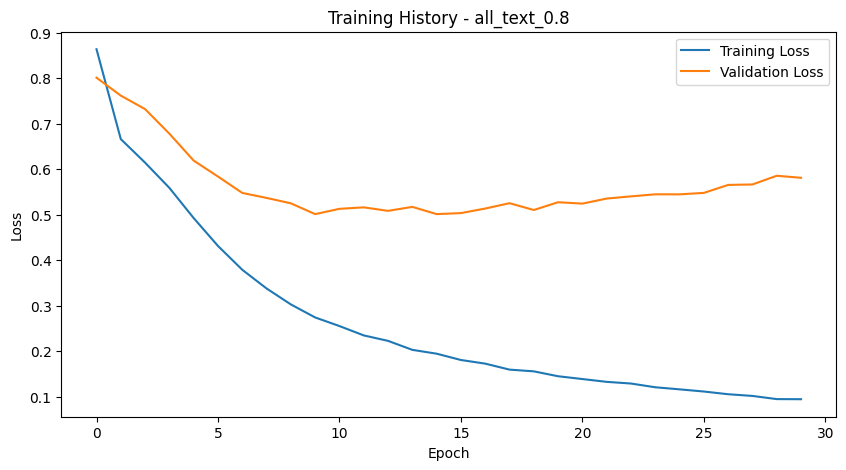

In [5]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-bug-data-comments-without-filenames/Bug Data with comments without changed files.csv",
                        help='Path to the data file (JSON or CSV format)')
    parser.add_argument('--text_column', type=str, default='all_text_0.8',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=30, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', default=True,
                        help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true', 
                        help='Enable hybrid feature selection')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=10, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='count',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

# 0.9

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-bug-data-comments-without-filenames/Bug Data with comments without changed files.csv...
Loading tokenizer...

Applying token length filtering...


Calculating token lengths: 100%|██████████| 1258/1258 [00:05<00:00, 234.53it/s]


Token length statistics before filtering:
  Mean: 624.99, Std Dev: 900.26
  Min: 9, Max: 12618
  25th percentile: 184.25
  50th percentile (median): 345.00
  75th percentile: 713.50
Applied 3.0 std dev threshold: (1.00, 3325.77)
Removed 20 samples by std dev filtering (1.59% of data)
Total removed: 20 samples (1.59% of original data)
Remaining: 1238 samples (98.41% of original data)

Token length statistics after all filtering:
  Mean: 543.83, Std Dev: 552.29
  Min: 9, Max: 3193
  25th percentile: 180.00
  50th percentile (median): 338.00
  75th percentile: 677.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 1238
Dataset size after basic cleaning: 1238 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 39
Removed 19 infrequent labels (48.72% of labels)
Number of labels remaining: 20 (51.28% of labels)
Removed 15 samples with no labels
Samples remaining after label filtering: 1223 (98.79% of data)

Ste

Calculating token lengths: 100%|██████████| 1100/1100 [00:03<00:00, 303.87it/s]



=== TOKEN LENGTH SUMMARY ===
Maximum token length: 3124
Mean token length: 538.37
Median token length: 324.00
Encoding labels...
Label density: 0.0634
Average labels per sample: 1.20
Feature selection enabled: False
Feature selection disabled
Feature selection disabled, using all labels
Training samples: 880, Validation samples: 220
Loading tokenizer...
Computing class weights for imbalanced labels...
Using larger batch size of 32 for 2 GPUs
Initializing model...
Model wrapped in DataParallel
Using weighted BCE loss
Starting training for 30 epochs...

Epoch 1/30


Training: 100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


Train Loss: 0.8578, Train Accuracy (Exact Match): 0.0045
Val Loss: 0.7908
Val Accuracy (Exact Match): 0.0136
Val Accuracy (Partial Match): 0.1955
Val Accuracy (Jaccard): 0.1091
Val Precision: 0.1227, Val Recall: 0.1955, Val F1: 0.1462
Saved new best model to ./results/run_20250517_104412_all_text_0.9/best_model_all_text_0.9.pt

Epoch 2/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Train Loss: 0.6601, Train Accuracy (Exact Match): 0.0239
Val Loss: 0.7667
Val Accuracy (Exact Match): 0.0091
Val Accuracy (Partial Match): 0.3091
Val Accuracy (Jaccard): 0.1148
Val Precision: 0.1204, Val Recall: 0.3091, Val F1: 0.1674
Saved new best model to ./results/run_20250517_104412_all_text_0.9/best_model_all_text_0.9.pt

Epoch 3/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.6153, Train Accuracy (Exact Match): 0.0580
Val Loss: 0.7316
Val Accuracy (Exact Match): 0.0273
Val Accuracy (Partial Match): 0.4409
Val Accuracy (Jaccard): 0.1998
Val Precision: 0.2068, Val Recall: 0.4409, Val F1: 0.2718
Saved new best model to ./results/run_20250517_104412_all_text_0.9/best_model_all_text_0.9.pt

Epoch 4/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.5584, Train Accuracy (Exact Match): 0.1057
Val Loss: 0.6761
Val Accuracy (Exact Match): 0.1455
Val Accuracy (Partial Match): 0.5455
Val Accuracy (Jaccard): 0.3383
Val Precision: 0.3511, Val Recall: 0.5455, Val F1: 0.4091
Saved new best model to ./results/run_20250517_104412_all_text_0.9/best_model_all_text_0.9.pt

Epoch 5/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.4892, Train Accuracy (Exact Match): 0.1932
Val Loss: 0.6153
Val Accuracy (Exact Match): 0.1409
Val Accuracy (Partial Match): 0.5955
Val Accuracy (Jaccard): 0.3682
Val Precision: 0.3913, Val Recall: 0.5955, Val F1: 0.4497
Saved new best model to ./results/run_20250517_104412_all_text_0.9/best_model_all_text_0.9.pt

Epoch 6/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.4313, Train Accuracy (Exact Match): 0.2284
Val Loss: 0.5816
Val Accuracy (Exact Match): 0.1364
Val Accuracy (Partial Match): 0.6614
Val Accuracy (Jaccard): 0.3909
Val Precision: 0.4076, Val Recall: 0.6614, Val F1: 0.4835
Saved new best model to ./results/run_20250517_104412_all_text_0.9/best_model_all_text_0.9.pt

Epoch 7/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.3767, Train Accuracy (Exact Match): 0.2705
Val Loss: 0.5469
Val Accuracy (Exact Match): 0.1909
Val Accuracy (Partial Match): 0.6727
Val Accuracy (Jaccard): 0.4345
Val Precision: 0.4549, Val Recall: 0.6727, Val F1: 0.5205
Saved new best model to ./results/run_20250517_104412_all_text_0.9/best_model_all_text_0.9.pt

Epoch 8/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.3323, Train Accuracy (Exact Match): 0.3170
Val Loss: 0.5323
Val Accuracy (Exact Match): 0.2182
Val Accuracy (Partial Match): 0.6977
Val Accuracy (Jaccard): 0.4598
Val Precision: 0.4773, Val Recall: 0.6977, Val F1: 0.5458
Saved new best model to ./results/run_20250517_104412_all_text_0.9/best_model_all_text_0.9.pt

Epoch 9/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.3013, Train Accuracy (Exact Match): 0.3489
Val Loss: 0.5276
Val Accuracy (Exact Match): 0.1909
Val Accuracy (Partial Match): 0.6500
Val Accuracy (Jaccard): 0.4136
Val Precision: 0.4303, Val Recall: 0.6500, Val F1: 0.4959

Epoch 10/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.2728, Train Accuracy (Exact Match): 0.3602
Val Loss: 0.5012
Val Accuracy (Exact Match): 0.3045
Val Accuracy (Partial Match): 0.7023
Val Accuracy (Jaccard): 0.5064
Val Precision: 0.5299, Val Recall: 0.7023, Val F1: 0.5795
Saved new best model to ./results/run_20250517_104412_all_text_0.9/best_model_all_text_0.9.pt

Epoch 11/30


Training: 100%|██████████| 28/28 [00:43<00:00,  1.54s/it]


Train Loss: 0.2529, Train Accuracy (Exact Match): 0.4227
Val Loss: 0.5151
Val Accuracy (Exact Match): 0.2318
Val Accuracy (Partial Match): 0.7023
Val Accuracy (Jaccard): 0.4705
Val Precision: 0.4917, Val Recall: 0.7023, Val F1: 0.5559

Epoch 12/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.2338, Train Accuracy (Exact Match): 0.4443
Val Loss: 0.5157
Val Accuracy (Exact Match): 0.2773
Val Accuracy (Partial Match): 0.6977
Val Accuracy (Jaccard): 0.4852
Val Precision: 0.5011, Val Recall: 0.6977, Val F1: 0.5605

Epoch 13/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.2168, Train Accuracy (Exact Match): 0.4534
Val Loss: 0.5080
Val Accuracy (Exact Match): 0.2818
Val Accuracy (Partial Match): 0.7136
Val Accuracy (Jaccard): 0.5004
Val Precision: 0.5193, Val Recall: 0.7136, Val F1: 0.5780

Epoch 14/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.2054, Train Accuracy (Exact Match): 0.4977
Val Loss: 0.5123
Val Accuracy (Exact Match): 0.3455
Val Accuracy (Partial Match): 0.7250
Val Accuracy (Jaccard): 0.5409
Val Precision: 0.5629, Val Recall: 0.7250, Val F1: 0.6102
Saved new best model to ./results/run_20250517_104412_all_text_0.9/best_model_all_text_0.9.pt

Epoch 15/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.1930, Train Accuracy (Exact Match): 0.4955
Val Loss: 0.5010
Val Accuracy (Exact Match): 0.3636
Val Accuracy (Partial Match): 0.7068
Val Accuracy (Jaccard): 0.5394
Val Precision: 0.5576, Val Recall: 0.7068, Val F1: 0.6020

Epoch 16/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1803, Train Accuracy (Exact Match): 0.5659
Val Loss: 0.5097
Val Accuracy (Exact Match): 0.3455
Val Accuracy (Partial Match): 0.7136
Val Accuracy (Jaccard): 0.5346
Val Precision: 0.5549, Val Recall: 0.7136, Val F1: 0.6017

Epoch 17/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1693, Train Accuracy (Exact Match): 0.5375
Val Loss: 0.5266
Val Accuracy (Exact Match): 0.3318
Val Accuracy (Partial Match): 0.7023
Val Accuracy (Jaccard): 0.5205
Val Precision: 0.5386, Val Recall: 0.7023, Val F1: 0.5876

Epoch 18/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1573, Train Accuracy (Exact Match): 0.5670
Val Loss: 0.5218
Val Accuracy (Exact Match): 0.3727
Val Accuracy (Partial Match): 0.7000
Val Accuracy (Jaccard): 0.5402
Val Precision: 0.5591, Val Recall: 0.7000, Val F1: 0.5997

Epoch 19/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.1553, Train Accuracy (Exact Match): 0.5818
Val Loss: 0.5197
Val Accuracy (Exact Match): 0.4045
Val Accuracy (Partial Match): 0.7159
Val Accuracy (Jaccard): 0.5606
Val Precision: 0.5788, Val Recall: 0.7159, Val F1: 0.6179
Saved new best model to ./results/run_20250517_104412_all_text_0.9/best_model_all_text_0.9.pt

Epoch 20/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1451, Train Accuracy (Exact Match): 0.6023
Val Loss: 0.5302
Val Accuracy (Exact Match): 0.3591
Val Accuracy (Partial Match): 0.7045
Val Accuracy (Jaccard): 0.5326
Val Precision: 0.5530, Val Recall: 0.7045, Val F1: 0.5952

Epoch 21/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.1372, Train Accuracy (Exact Match): 0.6273
Val Loss: 0.5214
Val Accuracy (Exact Match): 0.4000
Val Accuracy (Partial Match): 0.7159
Val Accuracy (Jaccard): 0.5674
Val Precision: 0.5917, Val Recall: 0.7159, Val F1: 0.6262
Saved new best model to ./results/run_20250517_104412_all_text_0.9/best_model_all_text_0.9.pt

Epoch 22/30


Training: 100%|██████████| 28/28 [00:43<00:00,  1.54s/it]


Train Loss: 0.1307, Train Accuracy (Exact Match): 0.6466
Val Loss: 0.5399
Val Accuracy (Exact Match): 0.3864
Val Accuracy (Partial Match): 0.6955
Val Accuracy (Jaccard): 0.5477
Val Precision: 0.5697, Val Recall: 0.6955, Val F1: 0.6042

Epoch 23/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1251, Train Accuracy (Exact Match): 0.6659
Val Loss: 0.5449
Val Accuracy (Exact Match): 0.3864
Val Accuracy (Partial Match): 0.7136
Val Accuracy (Jaccard): 0.5568
Val Precision: 0.5773, Val Recall: 0.7136, Val F1: 0.6164

Epoch 24/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1188, Train Accuracy (Exact Match): 0.6659
Val Loss: 0.5469
Val Accuracy (Exact Match): 0.3591
Val Accuracy (Partial Match): 0.7023
Val Accuracy (Jaccard): 0.5413
Val Precision: 0.5629, Val Recall: 0.7023, Val F1: 0.6039

Epoch 25/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.1167, Train Accuracy (Exact Match): 0.6750
Val Loss: 0.5468
Val Accuracy (Exact Match): 0.4227
Val Accuracy (Partial Match): 0.7136
Val Accuracy (Jaccard): 0.5792
Val Precision: 0.6030, Val Recall: 0.7136, Val F1: 0.6335
Saved new best model to ./results/run_20250517_104412_all_text_0.9/best_model_all_text_0.9.pt

Epoch 26/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.1111, Train Accuracy (Exact Match): 0.6977
Val Loss: 0.5479
Val Accuracy (Exact Match): 0.4227
Val Accuracy (Partial Match): 0.7136
Val Accuracy (Jaccard): 0.5750
Val Precision: 0.5955, Val Recall: 0.7136, Val F1: 0.6285

Epoch 27/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1063, Train Accuracy (Exact Match): 0.7011
Val Loss: 0.5662
Val Accuracy (Exact Match): 0.3636
Val Accuracy (Partial Match): 0.7091
Val Accuracy (Jaccard): 0.5462
Val Precision: 0.5705, Val Recall: 0.7091, Val F1: 0.6089

Epoch 28/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.1035, Train Accuracy (Exact Match): 0.7102
Val Loss: 0.5780
Val Accuracy (Exact Match): 0.3318
Val Accuracy (Partial Match): 0.7045
Val Accuracy (Jaccard): 0.5292
Val Precision: 0.5545, Val Recall: 0.7045, Val F1: 0.5971

Epoch 29/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Train Loss: 0.0967, Train Accuracy (Exact Match): 0.7477
Val Loss: 0.5814
Val Accuracy (Exact Match): 0.3364
Val Accuracy (Partial Match): 0.6909
Val Accuracy (Jaccard): 0.5235
Val Precision: 0.5447, Val Recall: 0.6909, Val F1: 0.5877

Epoch 30/30


Training: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Train Loss: 0.0904, Train Accuracy (Exact Match): 0.7568
Val Loss: 0.5817
Val Accuracy (Exact Match): 0.3864
Val Accuracy (Partial Match): 0.7000
Val Accuracy (Jaccard): 0.5538
Val Precision: 0.5765, Val Recall: 0.7000, Val F1: 0.6112

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4227
Partial Match Accuracy: 0.7136
Jaccard Similarity: 0.5792
Precision: 0.6030
Recall: 0.7136
F1 Score: 0.6335

Training completed! Results saved to ./results/run_20250517_104412_all_text_0.9


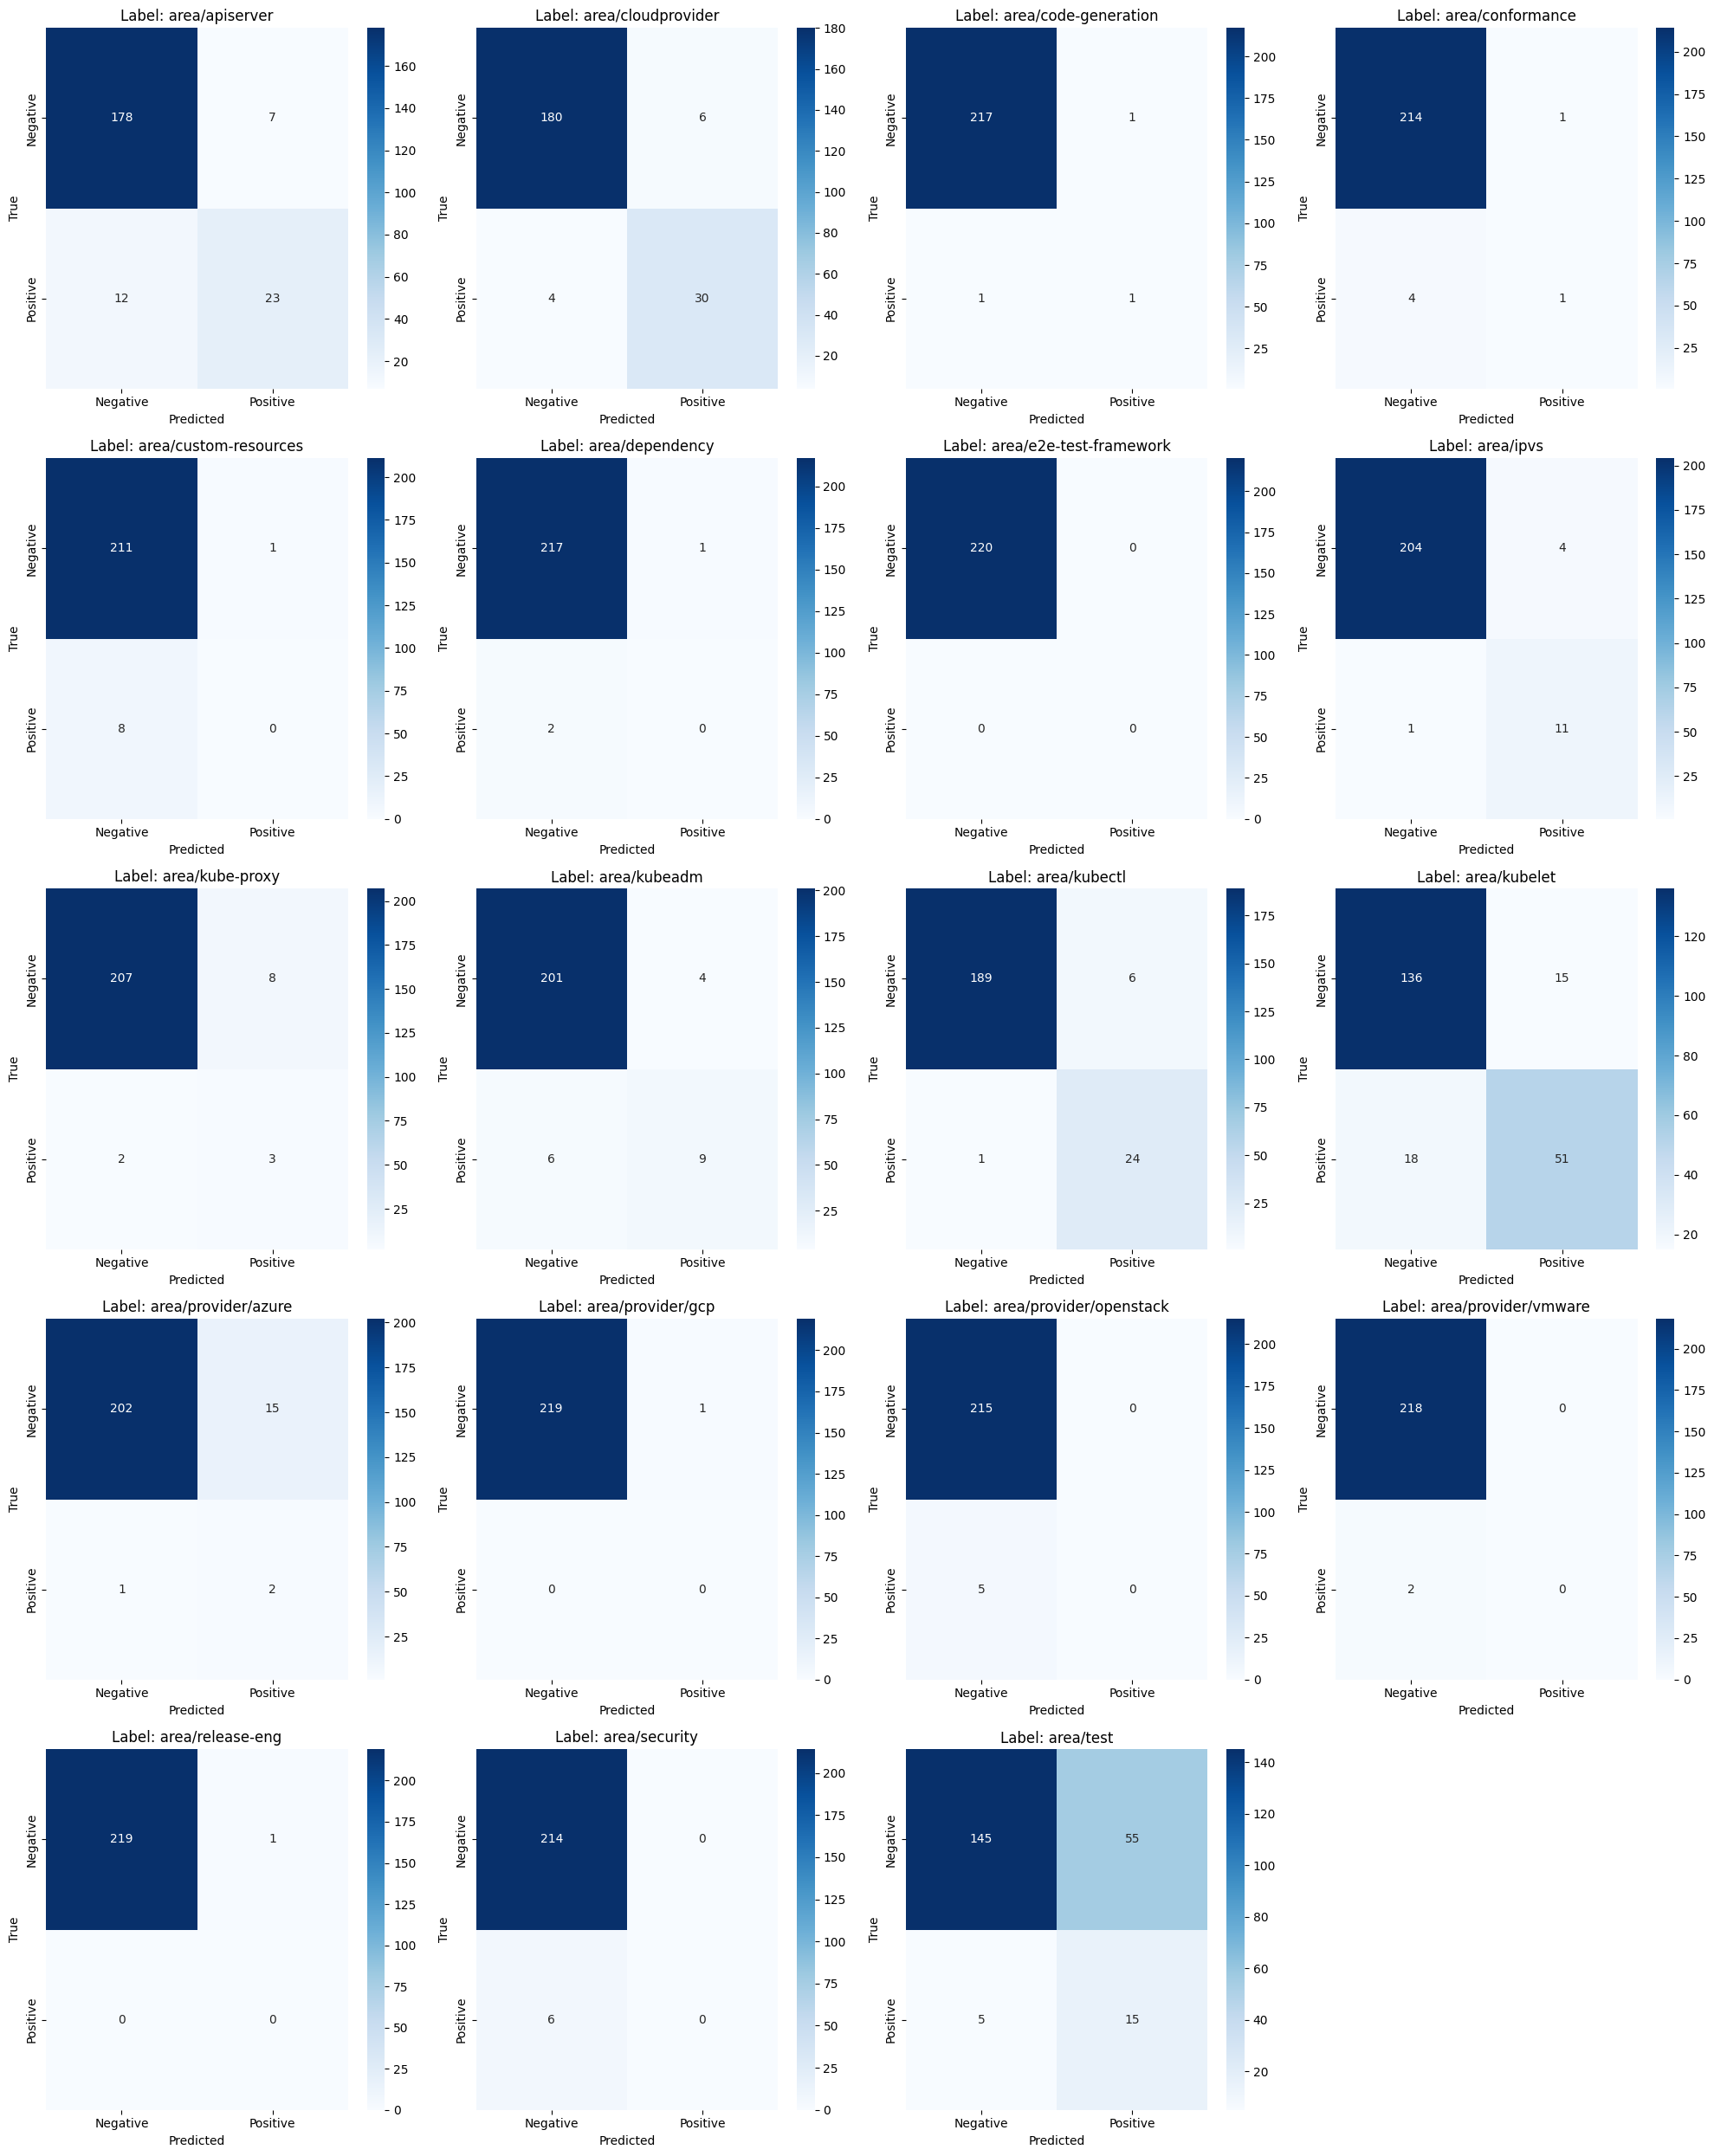

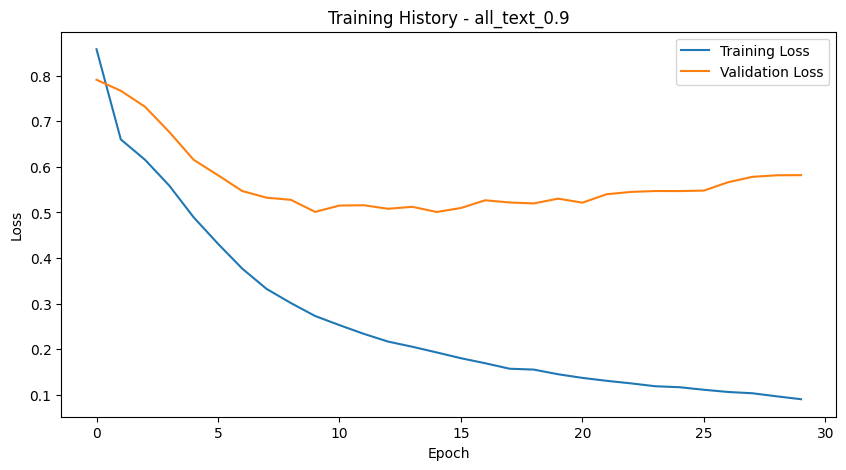

In [6]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-bug-data-comments-without-filenames/Bug Data with comments without changed files.csv",
                        help='Path to the data file (JSON or CSV format)')
    parser.add_argument('--text_column', type=str, default='all_text_0.9',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=30, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', default=True,
                        help='Use class weights for imbalanced data')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Feature selection parameters
    parser.add_argument('--feature_selection', action='store_true', 
                        help='Enable hybrid feature selection')
    parser.add_argument('--filter_k', type=int, default=20, 
                        help='Number of labels to retain after filter stage')
    parser.add_argument('--final_k', type=int, default=10, 
                        help='Final number of labels to select')
    parser.add_argument('--vectorizer', type=str, choices=['count', 'tfidf'], default='count',
                        help='Vectorizer to use for feature selection')
    parser.add_argument('--wrapper_method', type=str, choices=['rf', 'lr'], default='rf',
                        help='Wrapper method to use for feature selection (rf: Random Forest, lr: Logistic Regression)')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)